In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from catboost import CatBoostClassifier
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from functools import cmp_to_key
import logging
import xgboost as xgb

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)
plt.subplots(figsize=(15,10))

%matplotlib inline

In [3]:
DATA_DIR = '/home/ryan/cs/datasets/microsoft'

In [4]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
len(dtypes)

83

In [6]:
%time train = pd.read_csv(join(DATA_DIR, 'train.csv'), dtype=dtypes)
%time test = pd.read_csv(join(DATA_DIR, 'test.csv'), dtype=dtypes)

CPU times: user 1min 11s, sys: 1.92 s, total: 1min 13s
Wall time: 1min 13s
CPU times: user 1min 5s, sys: 1.48 s, total: 1min 6s
Wall time: 1min 6s


In [16]:
train['AvSigVersion']

0          1.273.1735.0
1            1.263.48.0
2          1.273.1341.0
3          1.273.1527.0
4          1.273.1379.0
5          1.273.1094.0
6           1.273.845.0
7          1.273.1393.0
8           1.275.988.0
9           1.273.973.0
10          1.273.869.0
11         1.273.1826.0
12         1.273.1372.0
13          1.275.895.0
14          1.273.925.0
15          1.275.130.0
16          1.275.300.0
17          1.273.466.0
18           1.277.48.0
19         1.273.1795.0
20          1.273.781.0
21          1.273.356.0
22          1.275.488.0
23          1.275.173.0
24          1.275.879.0
25           1.275.91.0
26         1.273.1376.0
27           1.277.25.0
28           1.275.26.0
29         1.273.1561.0
               ...     
8921453    1.275.1244.0
8921454     1.275.727.0
8921455    1.275.1739.0
8921456     1.273.371.0
8921457    1.275.1727.0
8921458    1.275.1762.0
8921459    1.233.4235.0
8921460    1.275.1454.0
8921461     1.273.443.0
8921462     1.273.605.0
8921463    1.273

In [44]:
vals = train['Census_ProcessorCoreCount'].values
vals = vals.astype(int)
vals[vals<0] = 0
vals.mean()

3.9712235062264871

In [6]:
labels = train['HasDetections']
# train = train.drop('HasDetections', axis=1)

In [7]:
if 5244810 in train.index:
    train.loc[5244810,'AvSigVersion'] = '1.273.1144.0'
    train['AvSigVersion'].cat.remove_categories('1.2&#x17;3.1144.0',inplace=True)

In [8]:
def condense_feature(df, col, category_map, fill_with=None):
    feature = df[col]
    reverse_map = {}
    default_val = None
    categories = feature.unique()
    categories = categories[~pd.isnull(categories)]
    
    for k, v_arr in category_map.items():
        if len(v_arr) != 0:
            for v in v_arr:       
                reverse_map[v] = k
                index = np.argwhere(categories==v)
                categories = np.delete(categories, index)         
        else:
            default_val = k
            
    for v in categories:
        reverse_map[v] = default_val
        
    condensed = df[col].map(reverse_map)
    if fill_with:
        condensed = condensed.fillna(fill_with)
    else:
        condensed = condensed.fillna(default_val)
    
    return condensed

def generate_count_feature(df, col, counts=None):
    if counts is None:
        feature = df[col]
        groups = df.groupby(col)
        counts = groups.size()
    count_feature = df[col].map(counts)
    
    return count_feature, counts

def group_battery(x):
    x = x.lower()
    if ('li' in x) or ('ion' in x):
        return 1
    else:
        return 0
    
def generate_freq_feature(df, col, on='HasDetections', frequencies=None):
#     print(frequencies)
    if frequencies is None:
        groups = df.groupby(col)
        sizes = groups.size()
        sums = groups.sum()[on]
        frequencies = sums/sizes
    freq_feature = df[col].map(frequencies)
    
    return freq_feature, frequencies

def generate_version_mapping(df, col, num_splits=4, fill_val='0.0.0.0'):
    feature = df[col].astype(str)
    feature.fillna(fill_val)
    versions = feature.unique()
    
    def version_compare(x, y):
        x_splits = x.split('.')
        y_splits = y.split('.')
        for x_val, y_val in zip(x_splits, y_splits):
            try:
                int_x = int(x_val)
            except:
                int_x = 0
            try:
                int_y = int(y_val)
            except:
                int_y = 0
            if int_x > int_y:
                return 1
            elif int_x < int_y:
                return -1
        return 0

    sorted_versions = sorted(versions, key=cmp_to_key(version_compare))
    mapping = {}
    for i, v in enumerate(sorted_versions):
        mapping[v] = i
        
    return feature.map(mapping)

def generate_split_version(df, col, num_splits=4):
    feature = df[col].astype(str)
    sv = pd.DataFrame()
    for i in range(num_splits):
        sv[col + '_' + str(i)] = feature.apply(lambda x: x.split('.')[i]).astype(int)
        
    return sv


In [9]:
def generate_count_df(df, cols, counts_map={}):
    count_df = pd.DataFrame()
    for col in cols:
        if col in counts_map:
            count_df[col + 'Counts'], _ = generate_count_feature(df, col, counts=counts_map[col])
        else:
            count_df[col + 'Counts'], counts_map[col] = generate_count_feature(df, col)
        
    return count_df, counts_map
        
def generate_freq_df(df, cols, freqs_map={}):
    freq_df = pd.DataFrame()
    for col in cols:
        if col in freqs_map:
            freq_df[col + 'Freqs'], _ = generate_freq_feature(df, col, frequencies=freqs_map[col])
        else:
            freq_df[col + 'Freqs'],  freqs_map[col] =  generate_freq_feature(df, col)
            
    return freq_df, freqs_map

def generate_category_df(df, cols):
    cat_df = pd.DataFrame()
    for col in cols:
        cat_df[col+'Cat'] = df[col].astype('category')
        
    return cat_df
        
def generate_boolean_df(df, cols):
    bool_df = pd.DataFrame()
    for col in cols:
        bool_df[col+'Bool'] = df[col].astype(np.bool)
        
    return bool_df
        
def generate_gb_df(df, cols):
    gb_df = pd.DataFrame()
    for col in cols:
        gb_df[col+'GB'] = df[col].fillna(df[col].median()).apply(lambda x: int(x/1000))
        
    return gb_df

In [10]:
import category_encoders as ce

In [35]:
def feature_engineer(df, frequencies_map={}, counts_map={}):

    # mine
    fe = pd.DataFrame()
    
    
    fe['MoreThanOneAV'] = condense_feature(df, 'AVProductsInstalled', {0: [0.0, 1.0], 1: []}, fill_with=0).astype(np.int8)
    
    fe['AVProductsEnabled'] = df['AVProductsEnabled'].fillna(0.0).astype(np.int8)

    
#     sku_feature = condense_feature(df, 'SkuEdition', {'Home': ['Home'], 'Pro': ['Pro'], 'SkuEtc':[]})
#     fe['SkuCondensed'] = sku_feature.astype('category')
    
#     fe['IsProtected'] = df['IsProtected'].astype(np.bool)
    
#     fe['SmartScreen'] = condense_feature(df, 'SmartScreen', 
#                                             {True: ['RequireAdmin', 'On', 'Warn', 'on', 'Enabled', 'warn', 'Block', 'Prompt', 'Promp', 'requireadmin', 'prompt', 'requireAdmin'], 
#                                              False: []}).astype(np.bool)
    
    
    
#     fe['CountryIdentifier'] = df['CountryIdentifier'].astype('category')
    
#     fe['EngineVersionMapped'] = generate_version_mapping(df, 'EngineVersion')
#     fe = fe.join(generate_split_version(df, 'EngineVersion'))
    
#     fe['AppVersionMapped'] = generate_version_mapping(df, 'AppVersion')
#     fe = fe.join(generate_split_version(df, 'AppVersion'))
    
#     fe['IeVerIdentifier'] = df['IeVerIdentifier'].fillna(0.0).astype(np.int16)
    
#     fe['ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].fillna(4.0).astype(np.int8)
    
    fe['Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].fillna(0.0).astype(np.int16)
    
#     fe['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
#     fe['BatteryType'] = df['Census_InternalBatteryType'].apply(group_battery)
    
#     fe['BatteryNumberOfCharges'] = df['Census_InternalBatteryNumberOfCharges'].fillna(df['Census_InternalBatteryNumberOfCharges'].median()).astype(np.int8)
    
#     fe['AvSigVersionMapped'] = generate_version_mapping(df, 'AvSigVersion')
#     fe = fe.join(generate_split_version(df, 'AvSigVersion'))
    
    count_cols = ['Platform', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier',
                  'CountryIdentifier', 'Census_OSVersion', 'CityIdentifier', 'OrganizationIdentifier', 'Processor',
                  'IeVerIdentifier', 'Census_MDC2FormFactor', 'OsBuild', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
                   'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision',
                  'Census_OSEdition', 'Census_OSInstallTypeName', 'Census_ActivationChannel',
                  'Census_FirmwareVersionIdentifier', 'Census_IsTouchEnabled', 'Census_OSUILocaleIdentifier']
    
    freq_cols = ['OrganizationIdentifier', 'CountryIdentifier', 'IeVerIdentifier', 
                 'Census_ActivationChannel', 'Census_FirmwareManufacturerIdentifier', 'Census_OSUILocaleIdentifier']
    
    category_cols = ['AVProductsInstalled','LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsBuild', 'OsSuite',
                     'OsPlatformSubRelease', 'IeVerIdentifier', 'Census_MDC2FormFactor', 
                     'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
                     'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
                     'Census_OSBranch', 'Census_OSInstallTypeName',
                     'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel', 'Census_FlightRing',
                     'Wdft_RegionIdentifier']
    
    gb_cols = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']
    
    boolean_cols = ['IsProtected', 'SMode', 'Firewall', 
                    'Census_HasOpticalDiskDrive', 'Census_GenuineStateName', 'Census_IsSecureBootEnabled', 
                    'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
                    'Wdft_IsGamer']
    
    
    
    count_df, counts_map = generate_count_df(df, count_cols, counts_map=counts_map)

#     freq_df, frequencies_map = generate_freq_df(df, freq_cols, freqs_map=frequencies_map)
    
    fe = fe.join(count_df)

#     fe = fe.join(freq_df)
    fe = fe.join(generate_category_df(df, category_cols))
#     fe = fe.join(generate_gb_df(df, gb_cols))
#     fe = fe.join(generate_boolean_df(df, boolean_cols))
    
    # importance from lgb_kernel
    
#     fe['OSVerOrdinal'] = generate_version_mapping(df, 'Census_OSVersion')
    fe['CountryIdentifier'] = df['CountryIdentifier']
    
#     ce_hash = ce.HashingEncoder(cols=['GeoNameIdentifier'])
#     ce_hash.fit(df, labels)
#     new_dat = ce_hash.transform(df)
#     fe = fe.join(new_dat)

    # important feature
    fe['GeoName'] = df['GeoNameIdentifier'].astype('category')
    
    fe['OSBuildRevision'] = df['Census_OSBuildRevision'].astype('category')
    fe['OSBuildLab'] = df['OsBuildLab'].astype('category')
    
    fe['FirmwareManufacturer'] = df['Census_FirmwareManufacturerIdentifier'].astype('category')
    fe['AppVersion'] = df['AppVersion']
    fe['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier'].astype('category')
    
    fe['OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    fe['OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    fe['OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    fe['OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')
    fe['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    fe['EngineVersion'] = df['EngineVersion'].astype('category')
    fe['Census_OSInstallTypeName'] = df['Census_OSInstallTypeName'].astype('category')
    
    
    
    return fe, frequencies_map, counts_map

In [36]:
print('Feature engineering train features...')
train_l1, freqs, counts = feature_engineer(train)
print('Feature engineering test features...')
test_l1, _, _ = feature_engineer(test, frequencies_map=freqs, counts_map=counts)
# test_l1 = train_l1

Feature engineering train features...
Feature engineering test features...


In [19]:
def trim(raw_tr, raw_te, col, fill='new', factor=5):

#     le = LabelEncoder().fit(np.unique(raw_tr[col].astype(str).unique().tolist()+raw_te[col].astype(str).unique().tolist()))
    agg_tr = raw_tr.groupby(col).size().to_frame('tr_counts').reset_index()
    agg_te = raw_te.groupby(col).size().to_frame('te_counts').reset_index()
    agg = pd.merge(agg_tr, agg_te, on=col, how='outer')
    agg = agg[agg['tr_counts'] > 1000].reset_index(drop=True)
    
    agg['total_counts'] = agg['tr_counts'] + agg['te_counts']
    agg = agg[(agg['tr_counts'] / agg['total_counts'] > (1.0/factor)) & (agg['tr_counts'] / agg['total_counts'] < ((factor-1.0)/factor))]

    agg[col+'_copy'] = agg[col]
    
    trim_tr = pd.merge(raw_tr[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy'].astype('category')
    trim_te = pd.merge(raw_te[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy'].astype('category')
    gc.collect()
    
    return trim_tr, trim_te

In [20]:
# for col in train_l1.columns.tolist():
#     train_l1[col], test_l1[col] = trim(train_l1, test_l1, col)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


In [37]:
test_l1.head()

,MoreThanOneAV,AVProductsEnabled,Census_ProcessorModelIdentifier,PlatformCounts,EngineVersionCounts,AppVersionCounts,AvSigVersionCounts,AVProductStatesIdentifierCounts,CountryIdentifierCounts,Census_OSVersionCounts,CityIdentifierCounts,OrganizationIdentifierCounts,ProcessorCounts,IeVerIdentifierCounts,Census_MDC2FormFactorCounts,OsBuildCounts,Census_ChassisTypeNameCounts,Census_PowerPlatformRoleNameCounts,Census_OSBranchCounts,Census_OSBuildNumberCounts,Census_OSBuildRevisionCounts,Census_OSEditionCounts,Census_OSInstallTypeNameCounts,Census_ActivationChannelCounts,Census_FirmwareVersionIdentifierCounts,Census_IsTouchEnabledCounts,Census_OSUILocaleIdentifierCounts,AVProductsInstalledCat,LocaleEnglishNameIdentifierCat,PlatformCat,ProcessorCat,OsBuildCat,OsSuiteCat,OsPlatformSubReleaseCat,IeVerIdentifierCat,Census_MDC2FormFactorCat,Census_ProcessorCoreCountCat,Census_ProcessorManufacturerIdentifierCat,Census_PrimaryDiskTypeNameCat,Census_ChassisTypeNameCat,Census_PowerPlatformRoleNameCat,Census_OSBranchCat,Census_OSInstallTypeNameCat,Census_OSWUAutoUpdateOptionsNameCat,Census_ActivationChannelCat,Census_FlightRingCat,Wdft_RegionIdentifierCat,CountryIdentifier,GeoName,OSBuildRevision,OSBuildLab,FirmwareManufacturer,AppVersion,AVProductStatesIdentifier,OSVersion_0,OSVersion_1,OSVersion_2,OSVersion_3,AvSigVersion_1,EngineVersion,Census_OSInstallTypeName
0,0,1,3064,8618715,NaN,NaN,NaN,5824565.0,397172,NaN,6469.0,1764175.0,346,474390.0,5723319.0,780270.0,5248812.0,6182908.0,797066.0,797049.0,NaN,3469991.0,649201,3413350,223.0,7801452,408118.0,1.0,42,windows10,x64,15063,768,rs2,108.0,Notebook,4.0,5.0,SSD,Notebook,Mobile,rs2_release,Reset,AutoInstallAndRebootAtMaintenanceTime,OEM:DM,Retail,7.0,43,53.0,1387,15063.0.amd64fre.rs2_release.170317-1834,807.0,4.18.1810.5,53447.0,10,0,15063,1387,281,1.1.15400.5,Reset
1,0,1,3410,8618715,NaN,13739.0,NaN,5824565.0,160158,216776.0,262.0,NaN,346,1767931.0,5723319.0,2503681.0,5248812.0,6182908.0,1199767.0,2443249.0,216776.0,3469991.0,2608037,4727589,89611.0,7801452,513995.0,1.0,74,windows10,x64,16299,768,rs3,117.0,Notebook,4.0,5.0,HDD,Notebook,Mobile,rs3_release_svc_escrow,UUPUpgrade,AutoInstallAndRebootAtMaintenanceTime,Retail,Retail,12.0,68,276.0,611,16299.431.amd64fre.rs3_release_svc_escrow.1805...,554.0,4.18.1809.2,53447.0,10,0,16299,611,279,1.1.15400.4,UUPUpgrade
2,1,1,2096,8618715,120295.0,13739.0,NaN,99899.0,220622,223775.0,64286.0,NaN,346,354411.0,5723319.0,730819.0,5248812.0,6182908.0,785534.0,785450.0,223775.0,1945461.0,840121,3413350,33316.0,7801452,206854.0,2.0,-5,windows10,x64,14393,768,rs1,98.0,Notebook,2.0,5.0,SSD,Notebook,Mobile,rs1_release,Other,UNKNOWN,OEM:DM,Retail,11.0,201,267.0,2189,14393.2189.amd64fre.rs1_release.180329-1711,556.0,4.18.1809.2,49480.0,10,0,14393,2189,277,1.1.15300.6,Other
3,1,1,1985,8618715,NaN,NaN,NaN,6025.0,347991,325267.0,19387.0,NaN,346,1767931.0,5723319.0,2503681.0,5248812.0,6182908.0,1237321.0,2443249.0,325267.0,1945461.0,1251559,3413350,6074.0,7801452,337988.0,2.0,-85,windows10,x64,16299,768,rs3,117.0,Notebook,2.0,5.0,HDD,Notebook,Mobile,rs3_release,Upgrade,Notify,OEM:DM,Retail,10.0,29,35.0,371,16299.15.amd64fre.rs3_release.170928-1534,628.0,4.18.1810.5,42160.0,10,0,16299,371,281,1.1.15400.5,Upgrade
4,0,1,3394,8618715,NaN,13739.0,NaN,5824565.0,280572,325267.0,22436.0,1764175.0,346,1767931.0,5723319.0,2503681.0,5248812.0,6182908.0,1237321.0,2443249.0,325267.0,1945461.0,1593308,4727589,39097.0,7801452,498236.0,1.0,-74,windows10,x64,16299,768,rs3,117.0,Notebook,4.0,5.0,HDD,Notebook,Mobile,rs3_release,Update,UNKNOWN,Retail,Retail,3.0,171,211.0,371,16299.15.amd64fre.rs3_release.170928-1534,556.0,4.18.1809.2,53447.0,10,0,16299,371,279,1.1.15400.4,Update


In [54]:
# params from https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
params = {'num_leaves': 256,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "lambda_l1": 0.15,
         "lambda_l2": 0.15,
         "random_state": 42,          
         "verbosity": -1}
n_fold = 2
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)

In [55]:
from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [56]:
# counts_to_try = ['Platform', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier',
#                   'CountryIdentifier', 'Census_OSVersion', 'CityIdentifier', 'OrganizationIdentifier', 'Processor',
#                   'IeVerIdentifier', 'Census_MDC2FormFactor', 'OsBuild', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
#                    'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision',
#                   'Census_OSEdition', 'Census_OSInstallTypeName', 'Census_ActivationChannel',
#                   'Census_FirmwareVersionIdentifier', 'Census_IsTouchEnabled', 'Census_OSUILocaleIdentifier']

counts_to_try = ['Census_FirmwareVersionIdentifierCounts', 'CityIdentifierCounts',
                 'AVProductStatesIdentifierCounts', 
                 'Census_OSVersionCounts', 'CountryIdentifierCounts', 'Census_OSBuildRevisionCounts']

running 0 1
Fold 1 started at Thu Feb 28 00:02:28 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600978	training's auc: 0.73916	valid_1's binary_logloss: 0.627627	valid_1's auc: 0.700321
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.599798	training's auc: 0.740729	valid_1's binary_logloss: 0.627616	valid_1's auc: 0.700347
Fold roc_auc: 0.700347214512

Fold 2 started at Thu Feb 28 00:35:27 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600933	training's auc: 0.739264	valid_1's binary_logloss: 0.62724	valid_1's auc: 0.700863
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.598885	training's auc: 0.741999	valid_1's binary_logloss: 0.627164	valid_1's auc: 0.70098
Fold roc_auc: 0.700979592843

CV mean score: 0.7007, std: 0.0003.
running 0 2
Fold 1 started at Thu Feb 28 01:10:08 2019
Training until validation scores don't improve for 200

Early stopping, best iteration is:
[504]	training's binary_logloss: 0.600811	training's auc: 0.739406	valid_1's binary_logloss: 0.627607	valid_1's auc: 0.700364
Fold roc_auc: 0.700364408808

Fold 2 started at Thu Feb 28 10:29:13 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600839	training's auc: 0.739395	valid_1's binary_logloss: 0.627264	valid_1's auc: 0.700856
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.598737	training's auc: 0.742199	valid_1's binary_logloss: 0.627223	valid_1's auc: 0.700921
Fold roc_auc: 0.700921366809

CV mean score: 0.7006, std: 0.0003.
running 2 0
Fold 1 started at Thu Feb 28 11:03:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600857	training's auc: 0.739309	valid_1's binary_logloss: 0.627551	valid_1's auc: 0.70044
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.600812	training's auc: 0.739376	valid

Fold 2 started at Thu Feb 28 20:22:52 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.60093	training's auc: 0.739253	valid_1's binary_logloss: 0.627307	valid_1's auc: 0.700792
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.600462	training's auc: 0.739866	valid_1's binary_logloss: 0.627255	valid_1's auc: 0.700867
Fold roc_auc: 0.700867125962

CV mean score: 0.7006, std: 0.0003.
running 3 5
Fold 1 started at Thu Feb 28 20:55:05 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600846	training's auc: 0.739365	valid_1's binary_logloss: 0.627565	valid_1's auc: 0.700443
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.600693	training's auc: 0.739571	valid_1's binary_logloss: 0.62756	valid_1's auc: 0.700451
Fold roc_auc: 0.7004513681

Fold 2 started at Thu Feb 28 21:26:22 2019
Training until validation scores don't improve for 200 rounds.
[500

Early stopping, best iteration is:
[575]	training's binary_logloss: 0.598461	training's auc: 0.742524	valid_1's binary_logloss: 0.62724	valid_1's auc: 0.700892
Fold roc_auc: 0.700891929218

CV mean score: 0.7007, std: 0.0002.
running 5 3
Fold 1 started at Fri Mar  1 06:47:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600846	training's auc: 0.739365	valid_1's binary_logloss: 0.627565	valid_1's auc: 0.700443
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.600693	training's auc: 0.739571	valid_1's binary_logloss: 0.62756	valid_1's auc: 0.700451
Fold roc_auc: 0.7004513681

Fold 2 started at Fri Mar  1 07:18:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.600825	training's auc: 0.739413	valid_1's binary_logloss: 0.627184	valid_1's auc: 0.700942
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.598629	training's auc: 0.742346	valid_1'

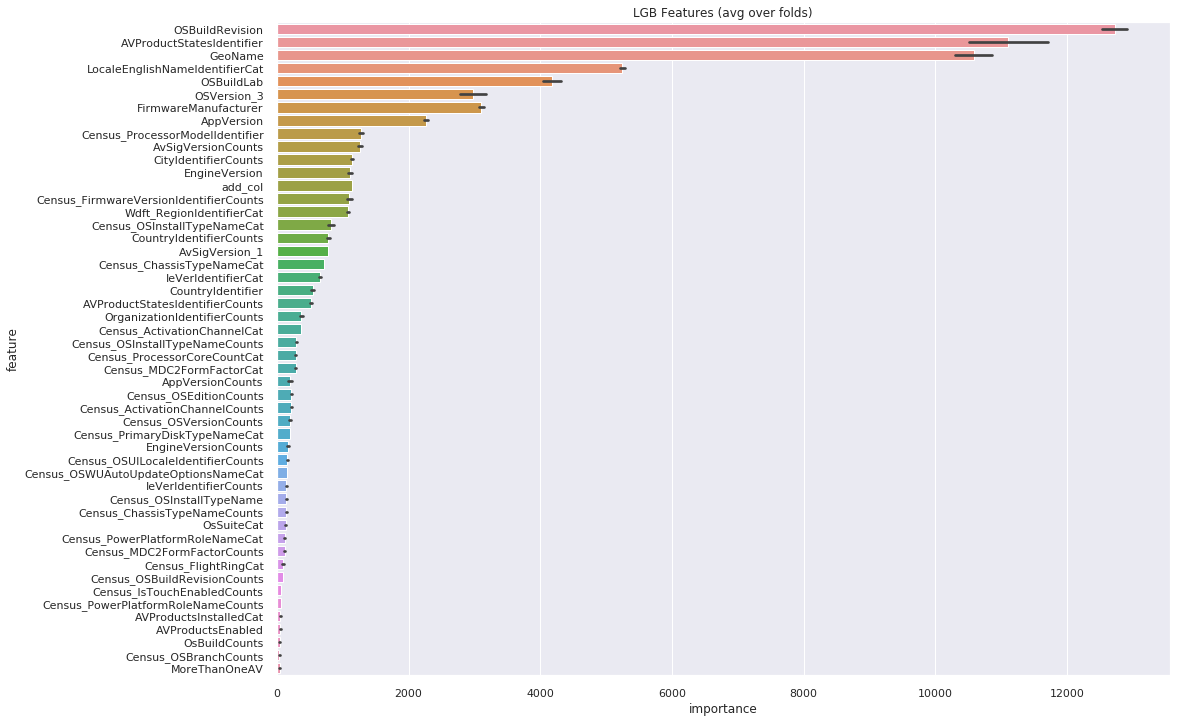

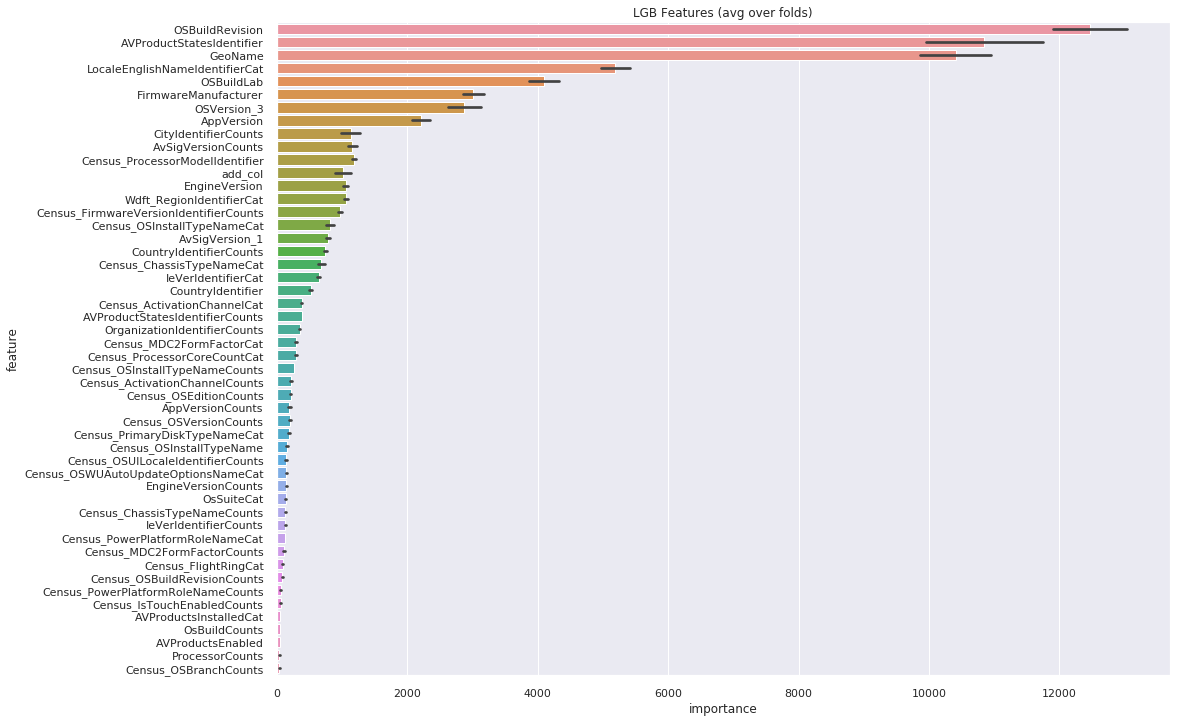

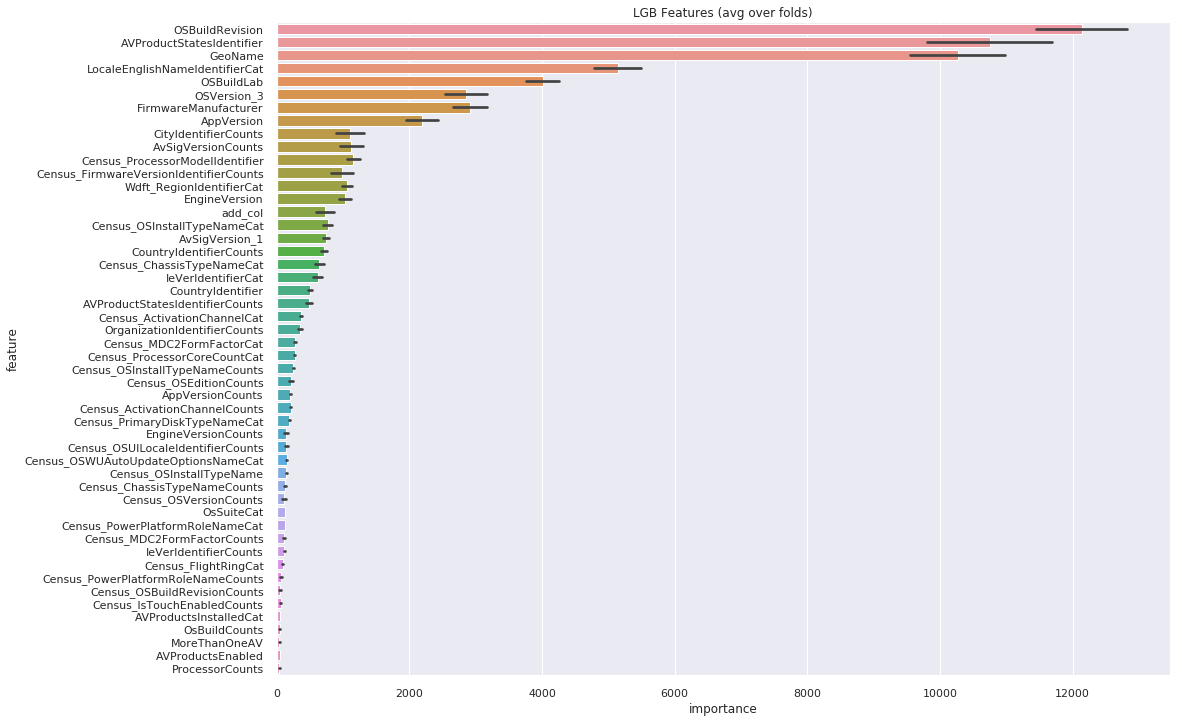

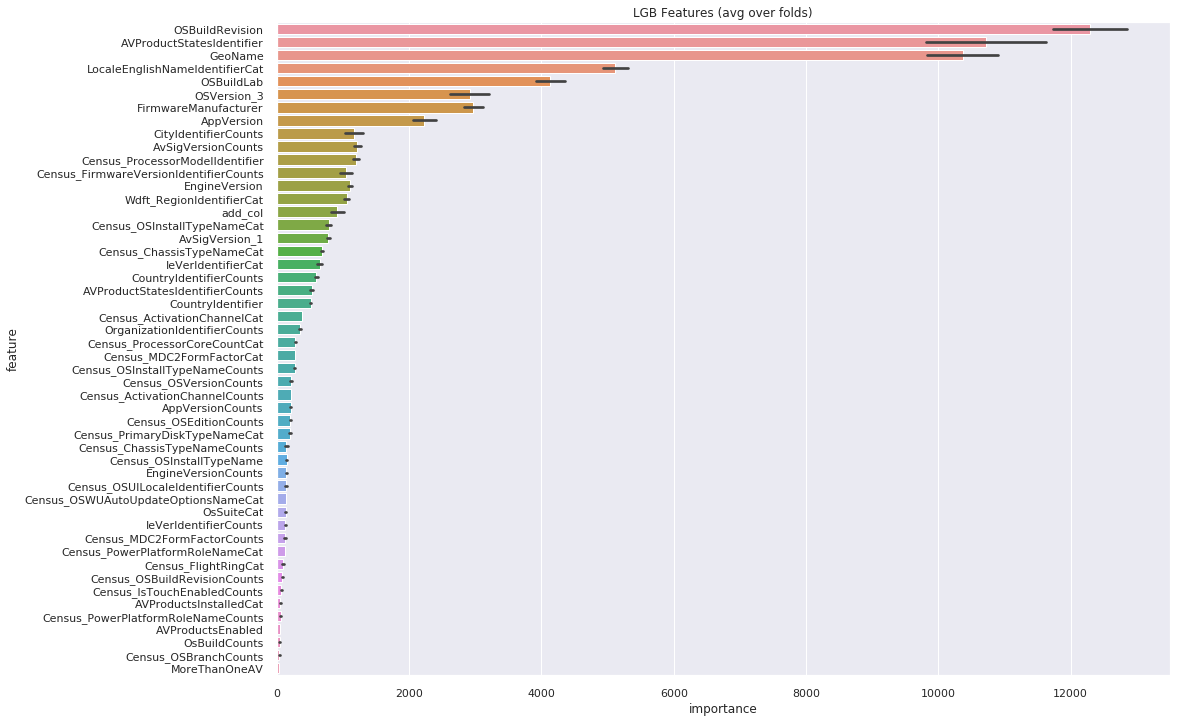

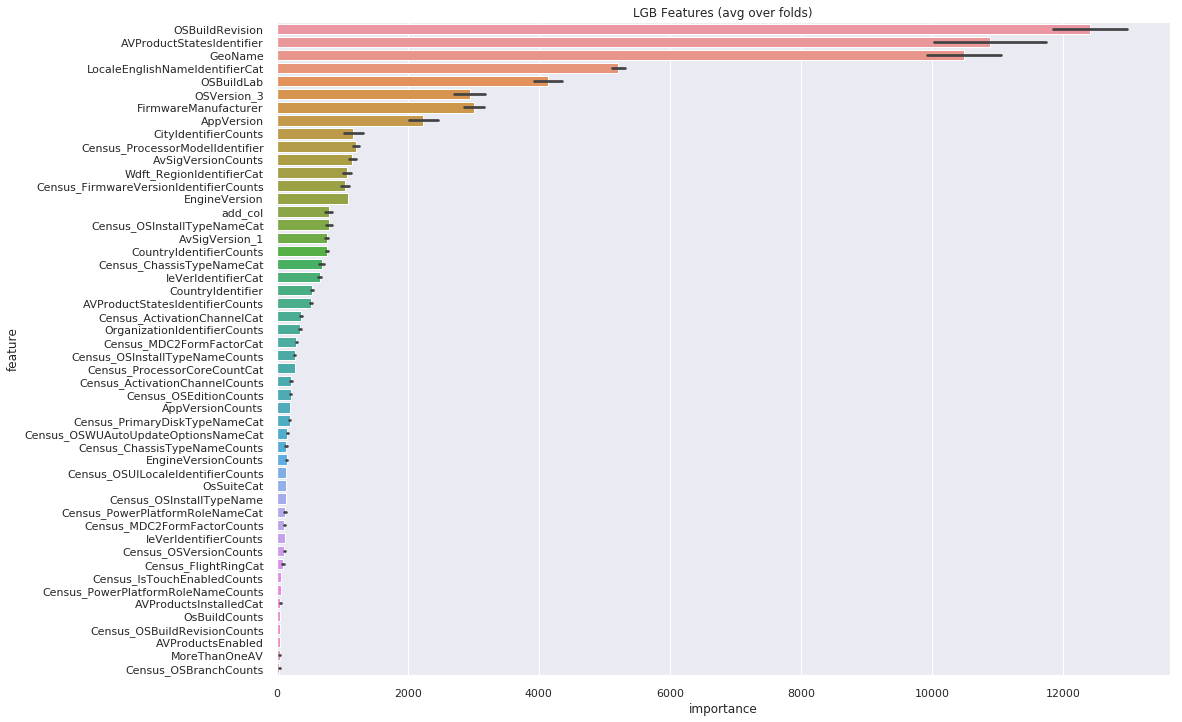

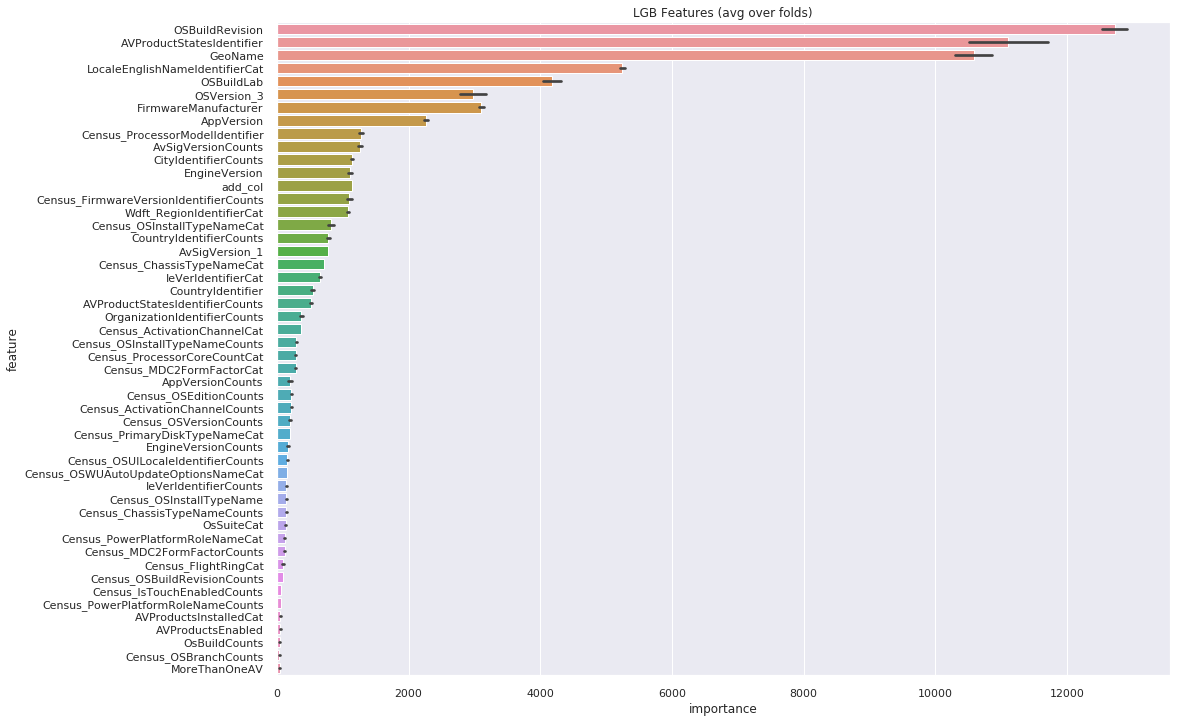

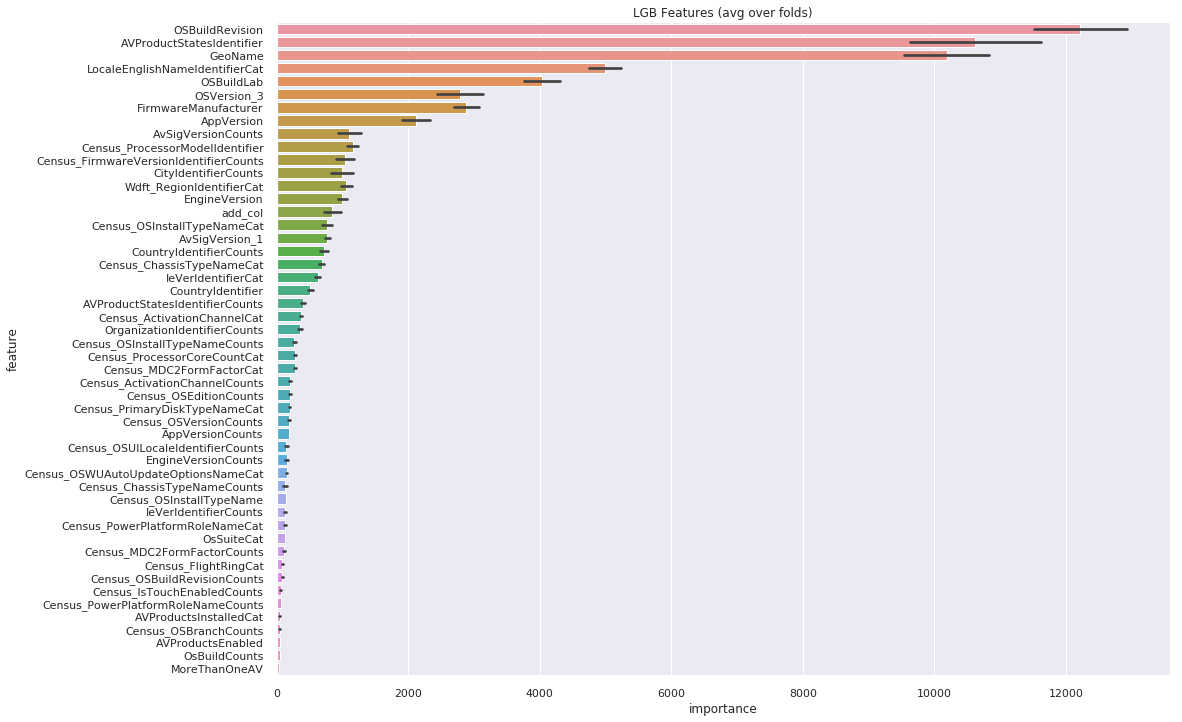

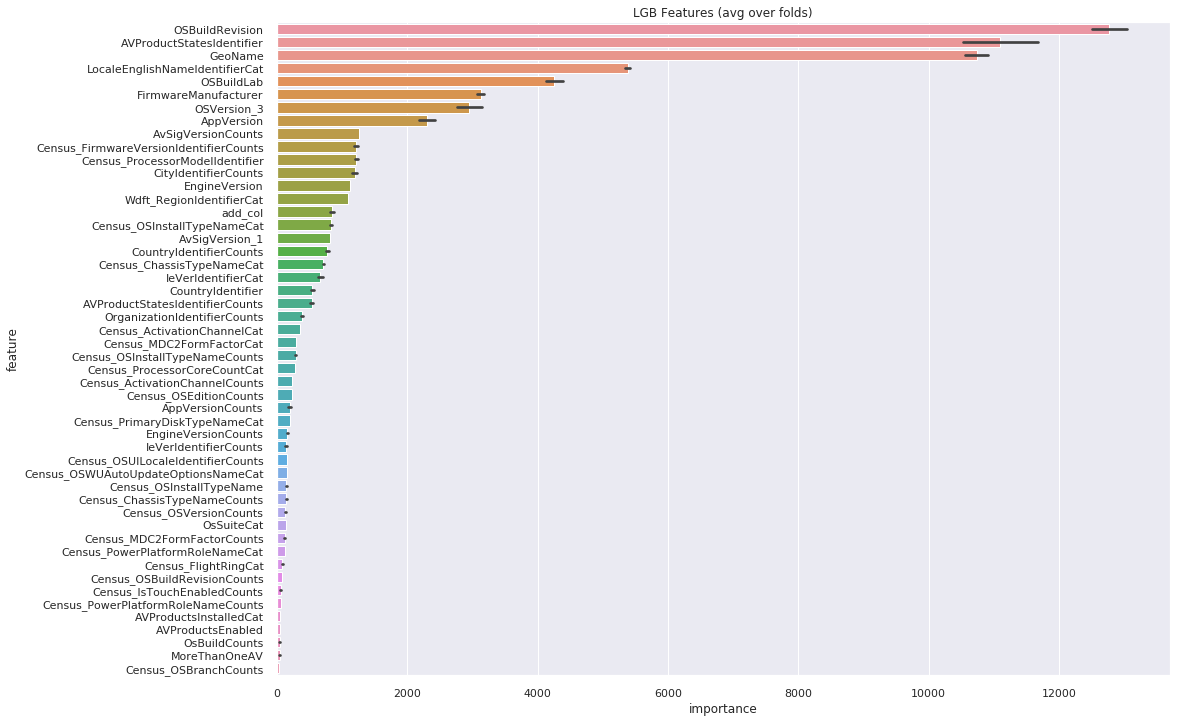

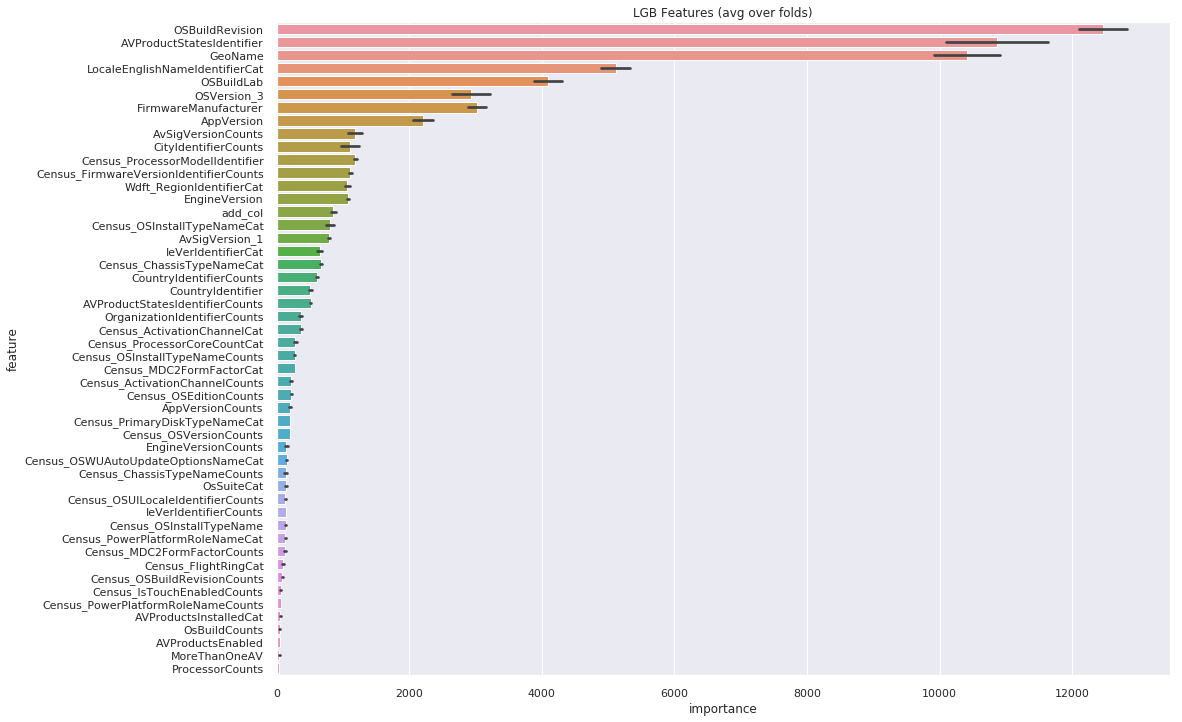

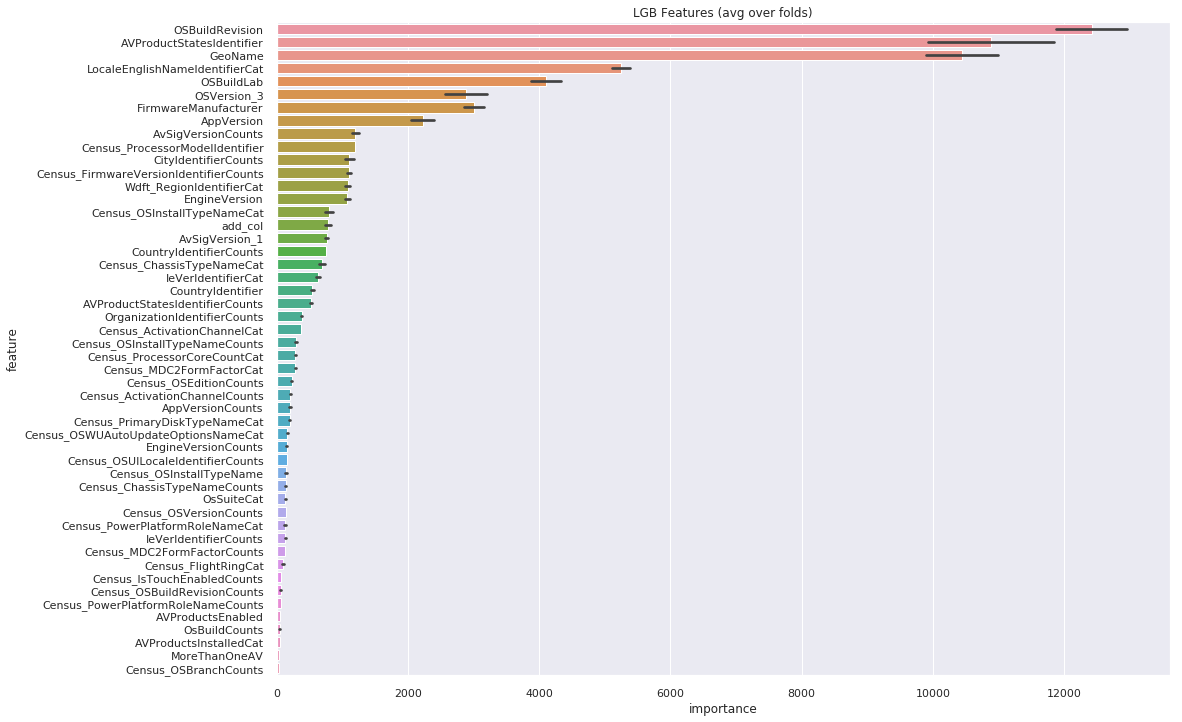

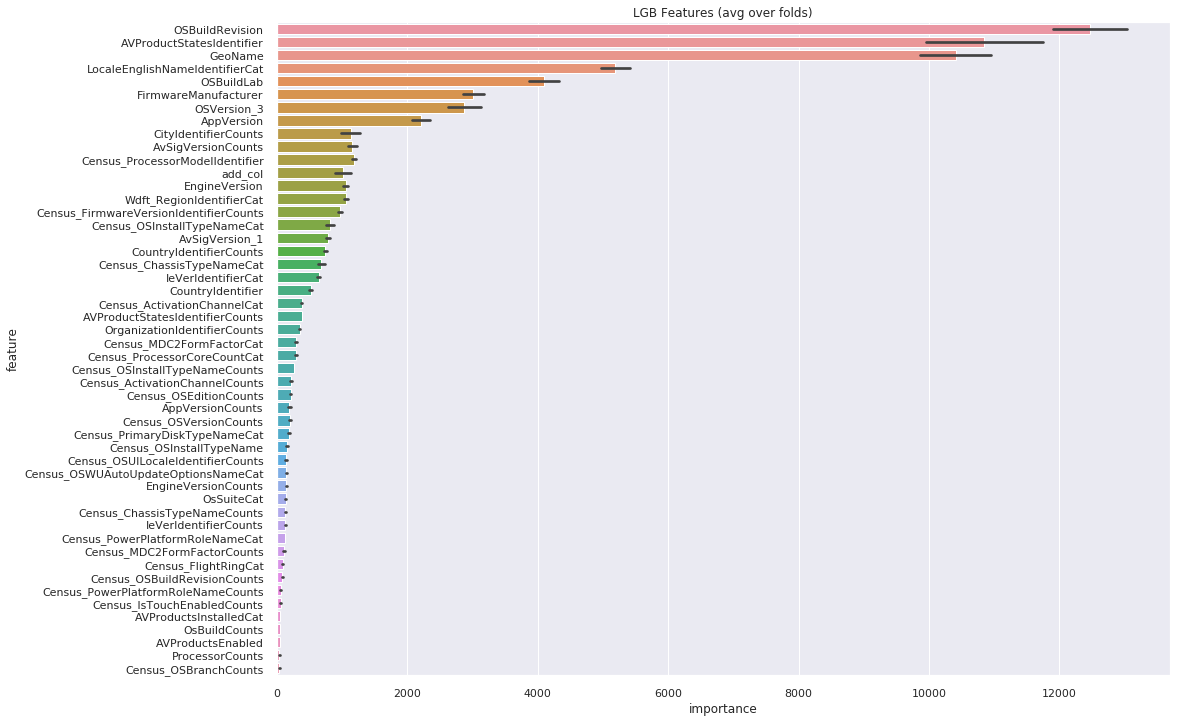

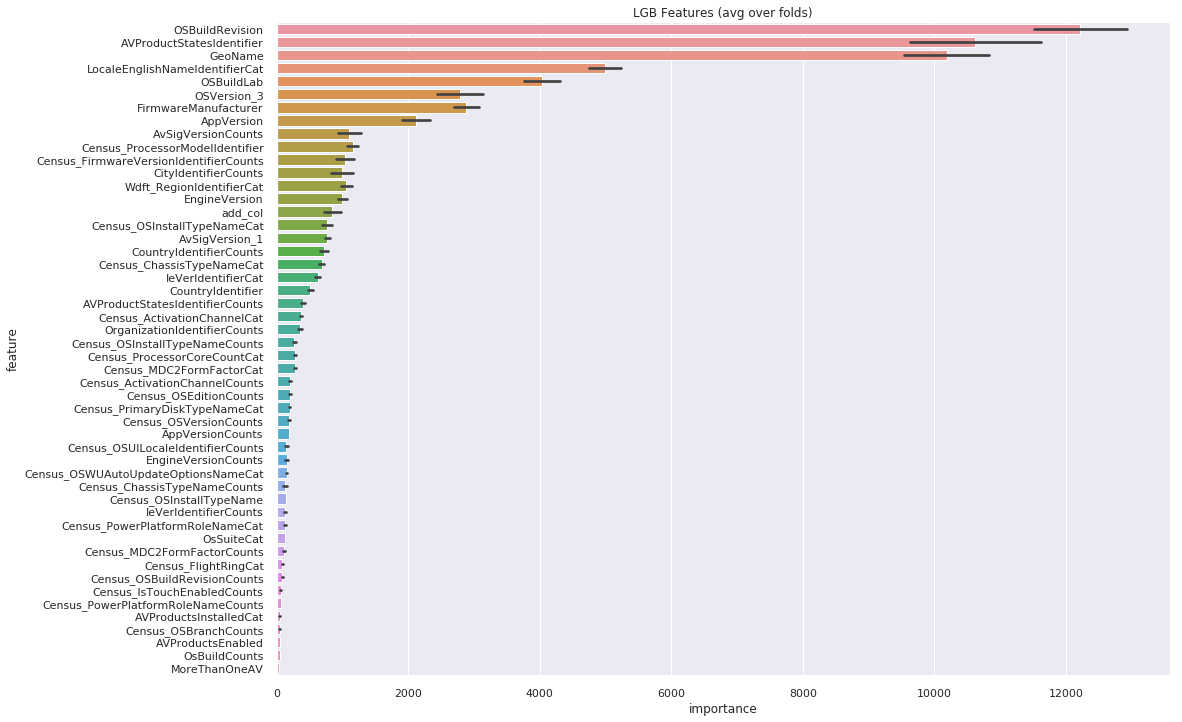

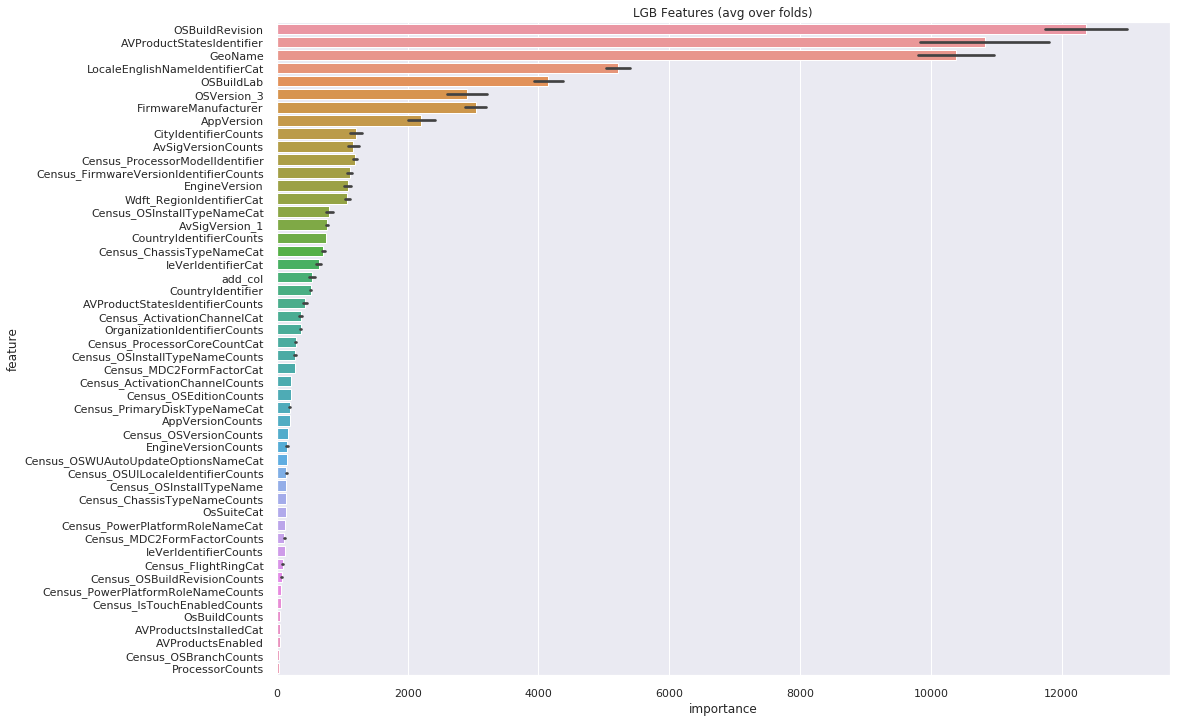

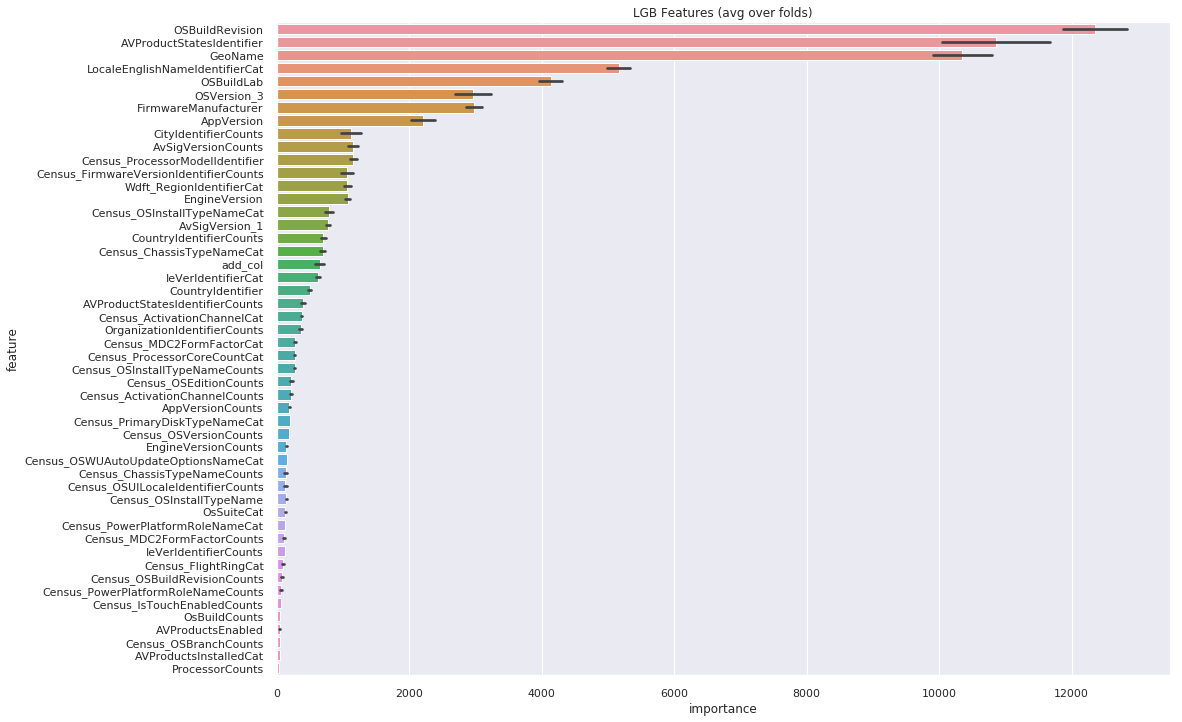

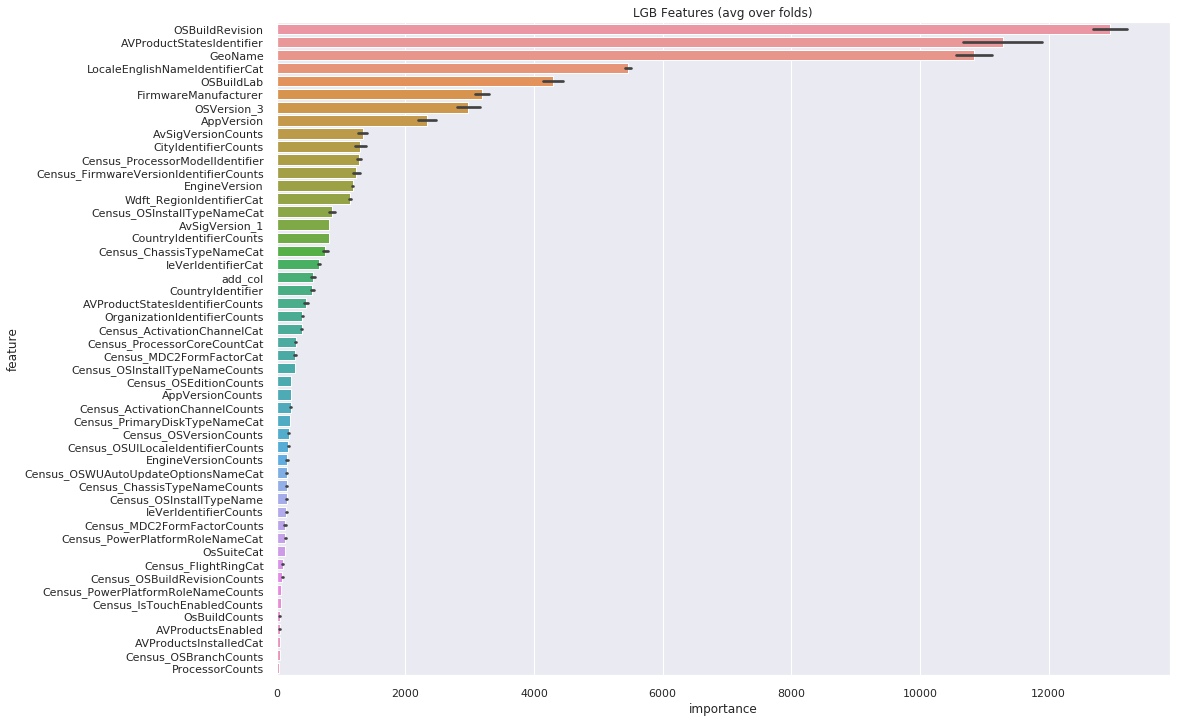

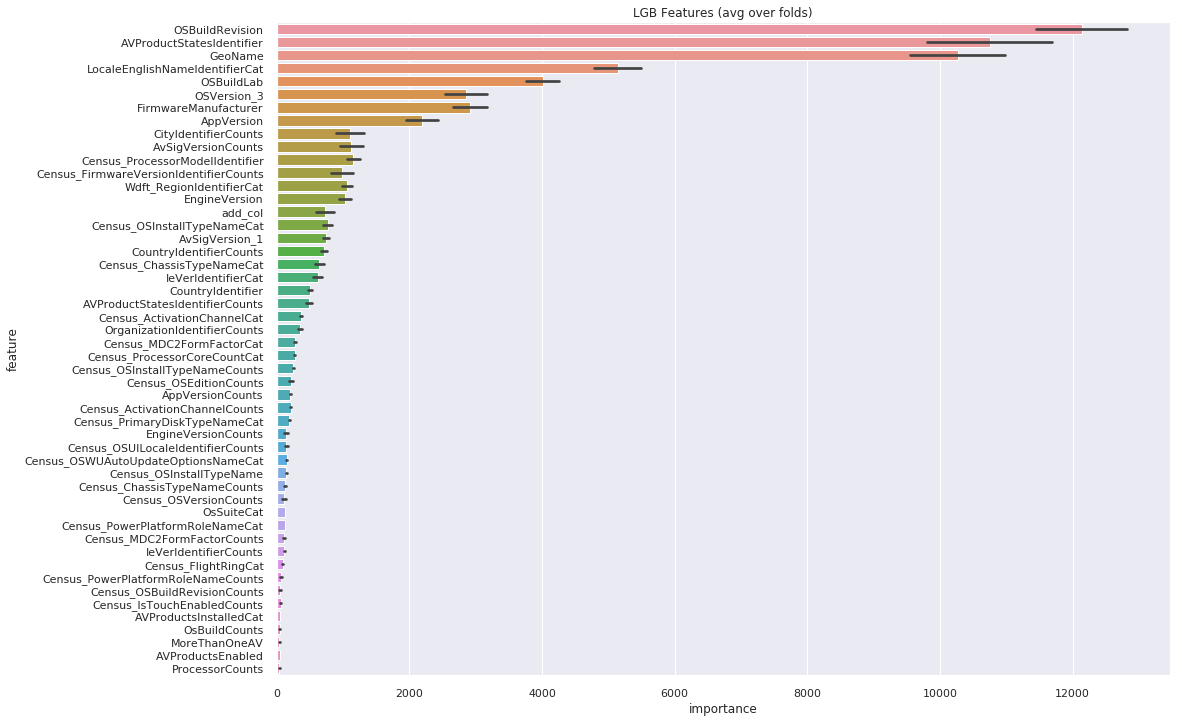

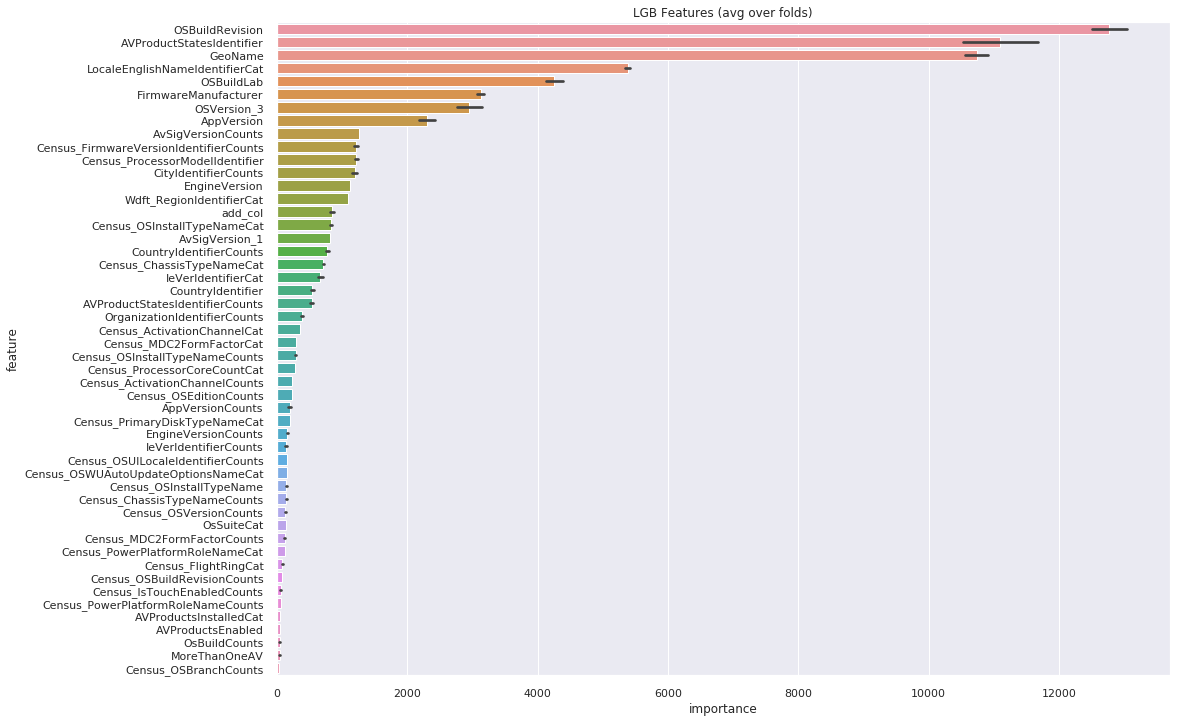

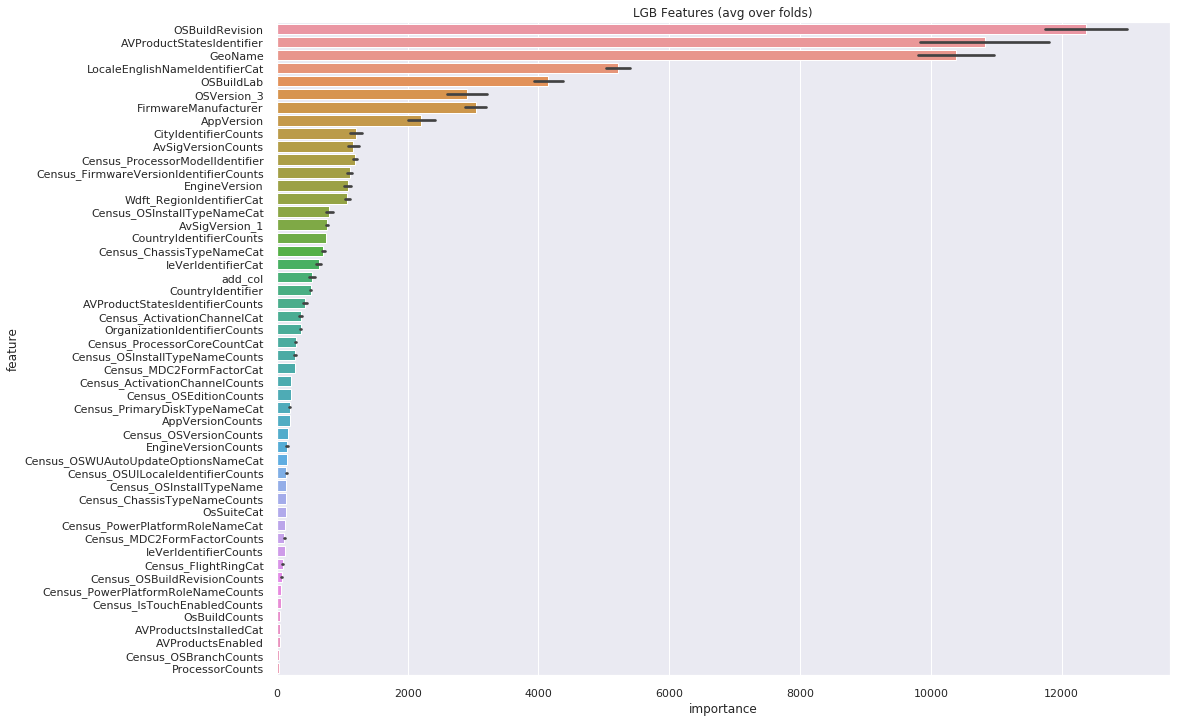

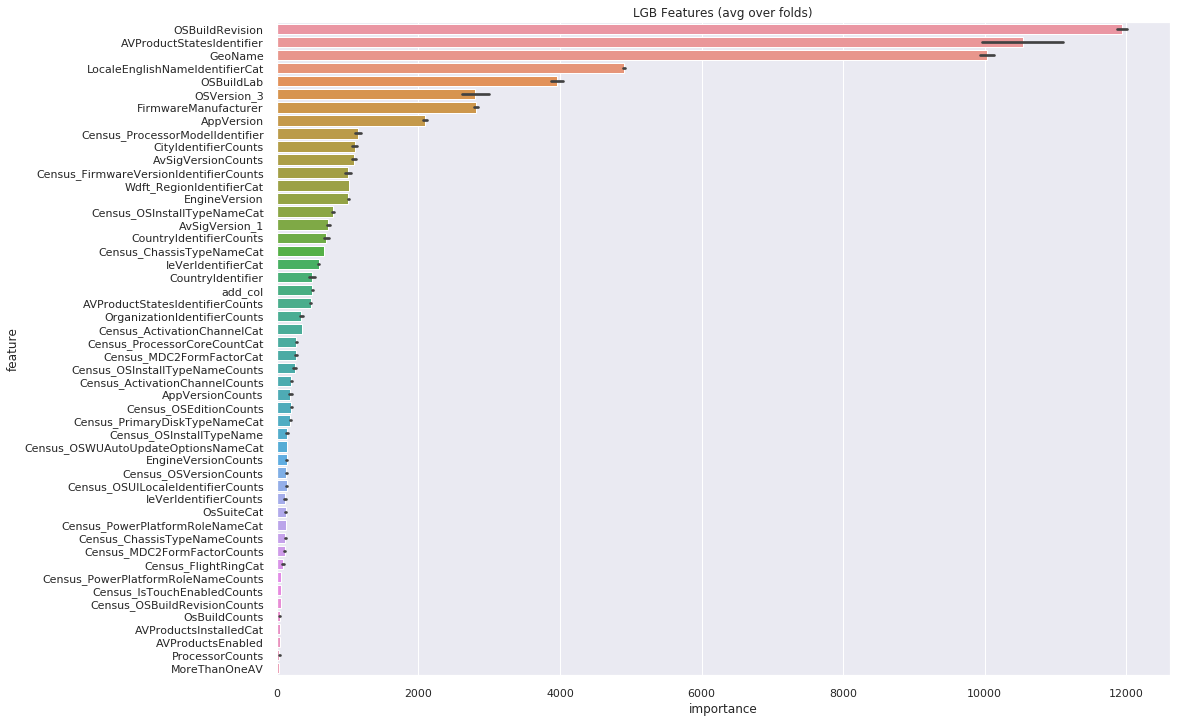

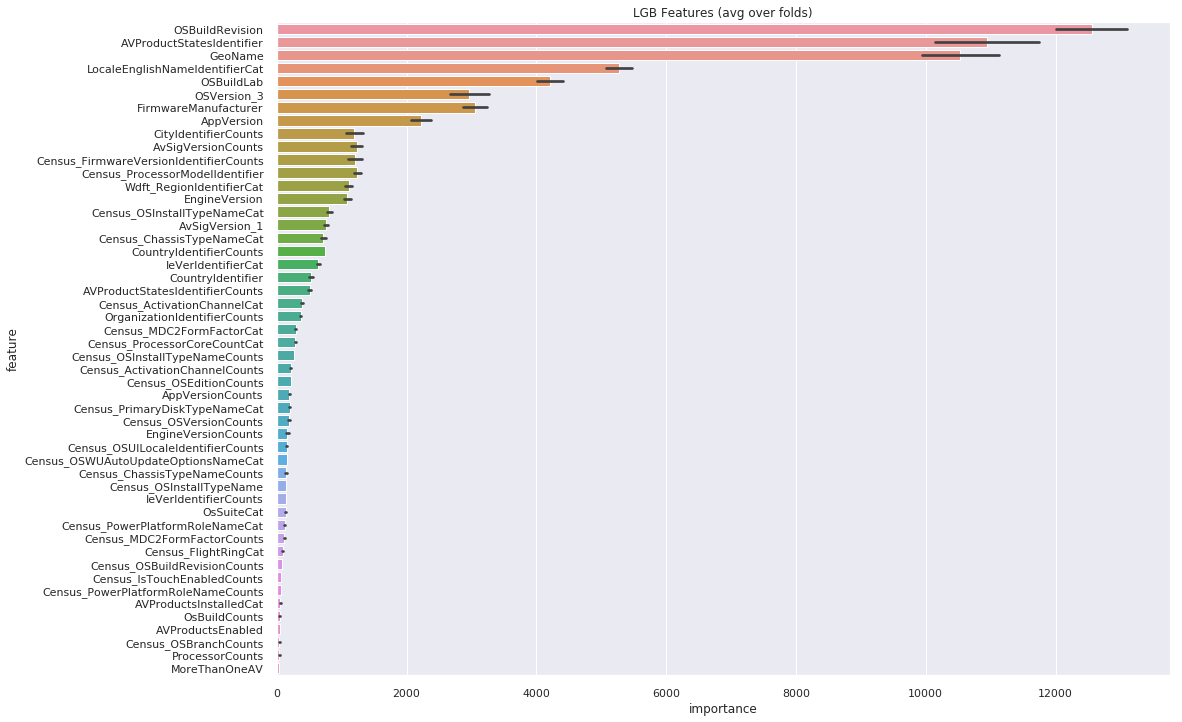

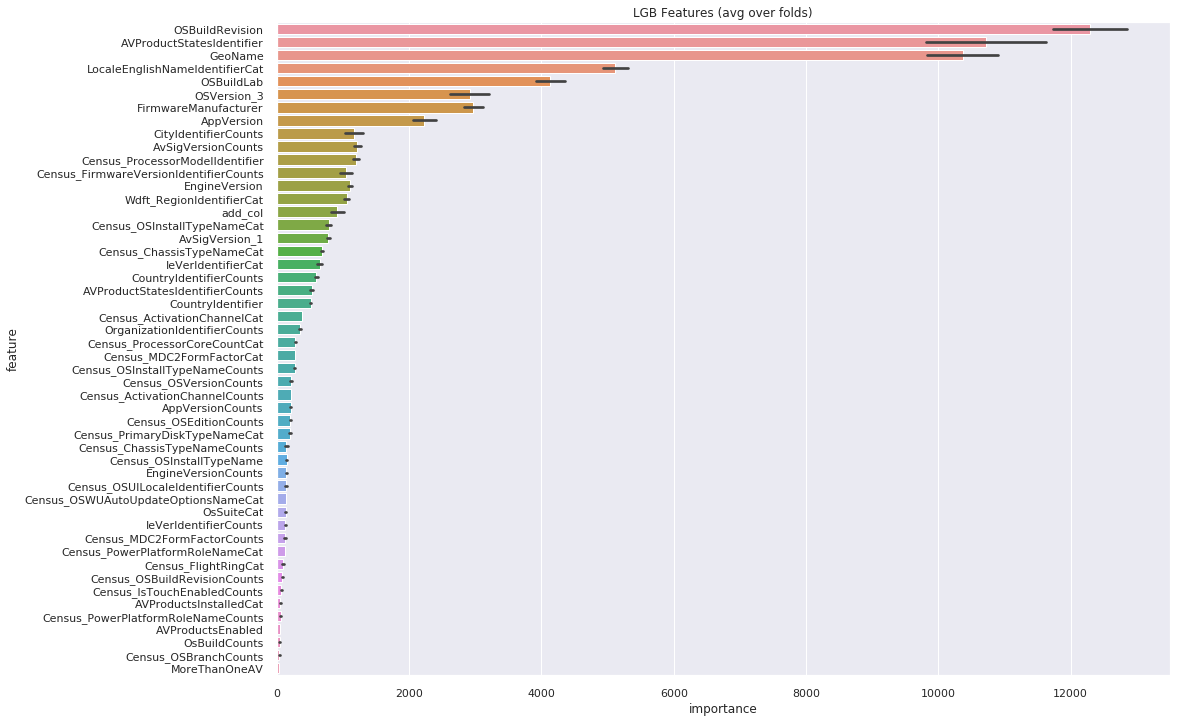

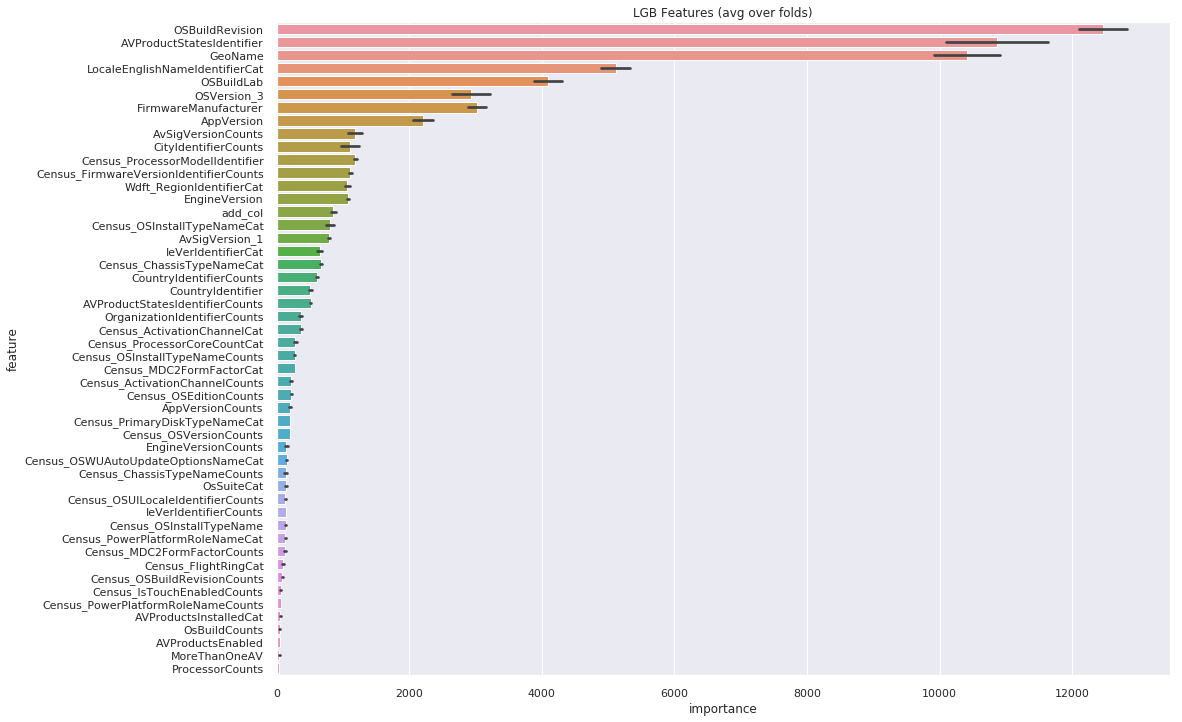

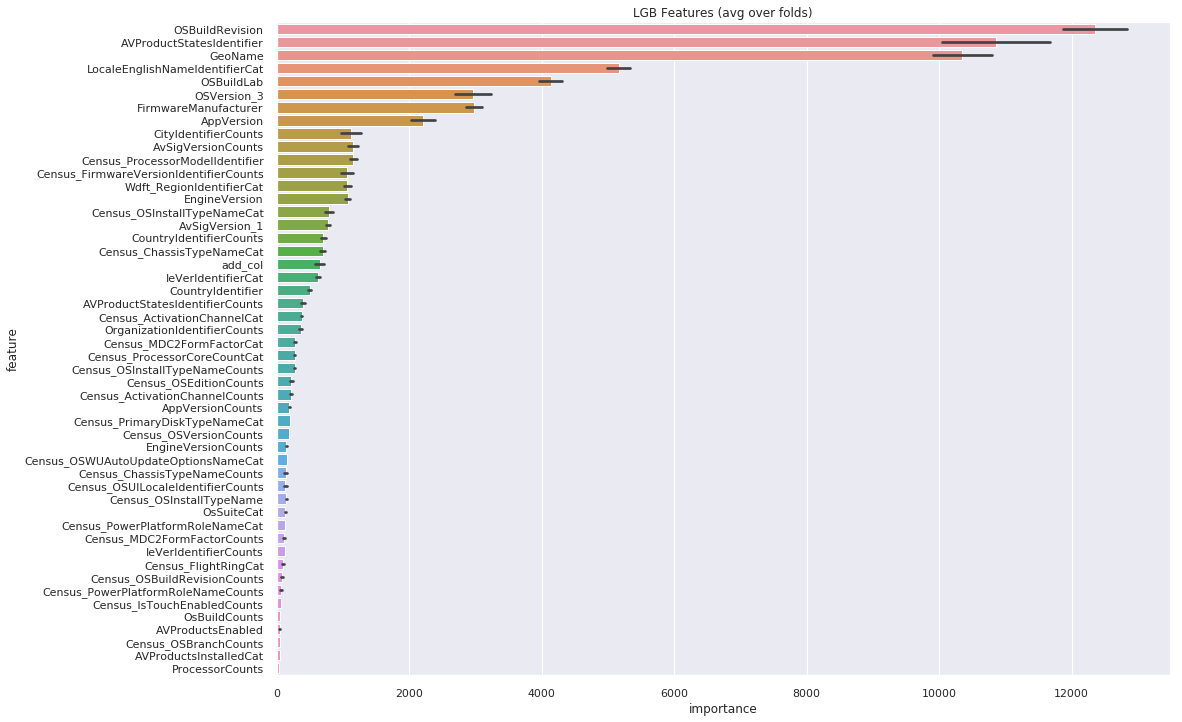

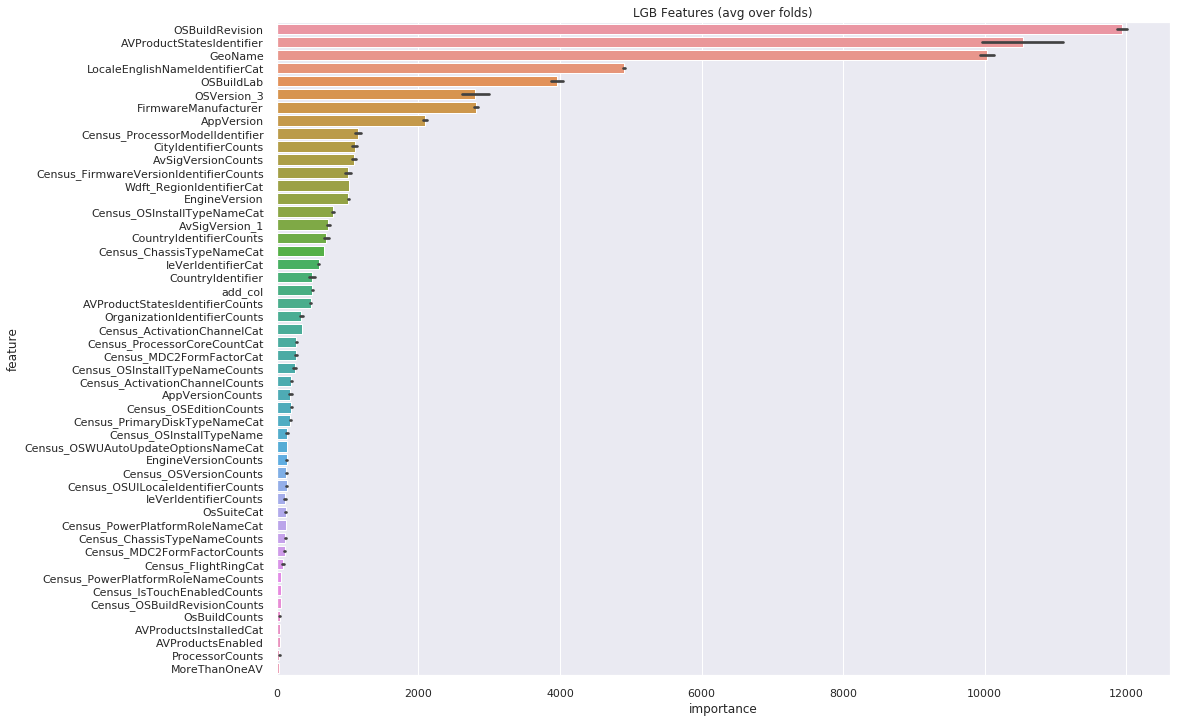

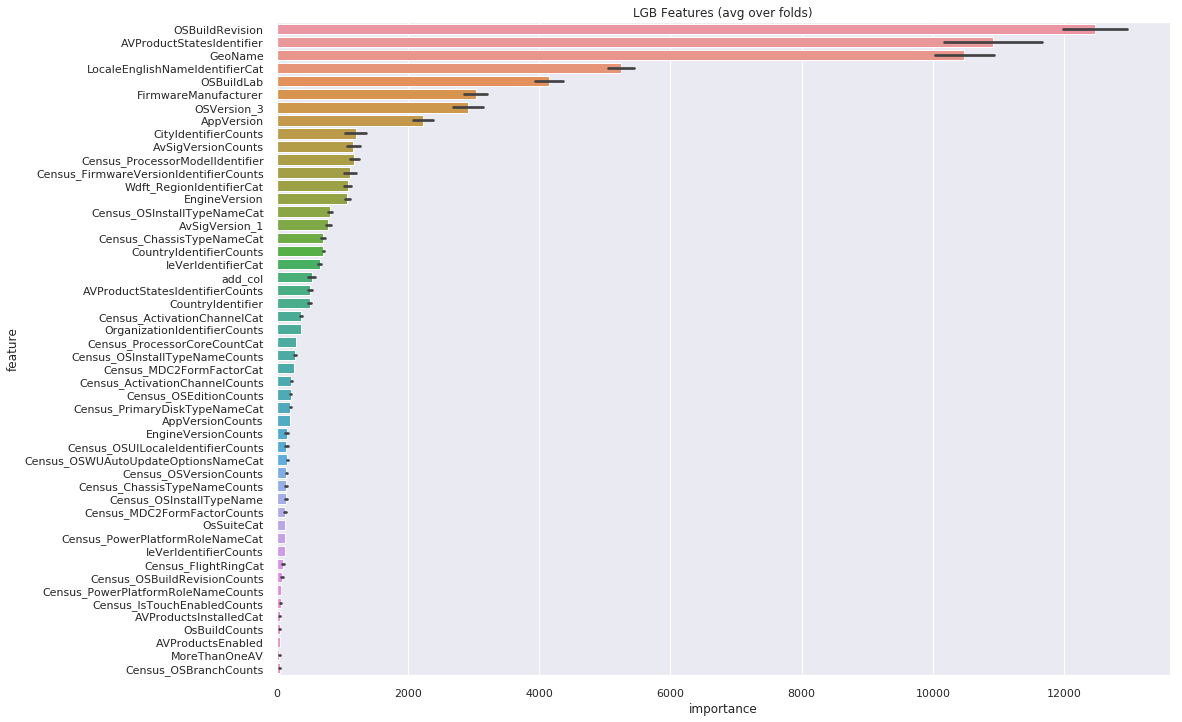

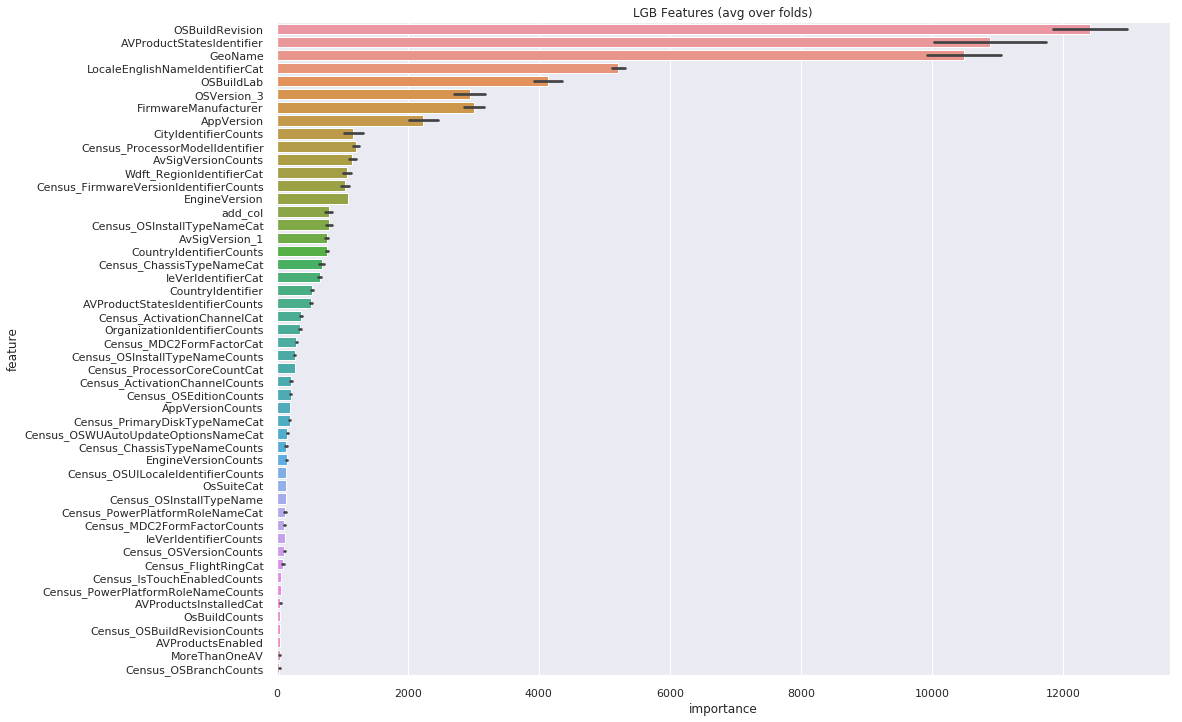

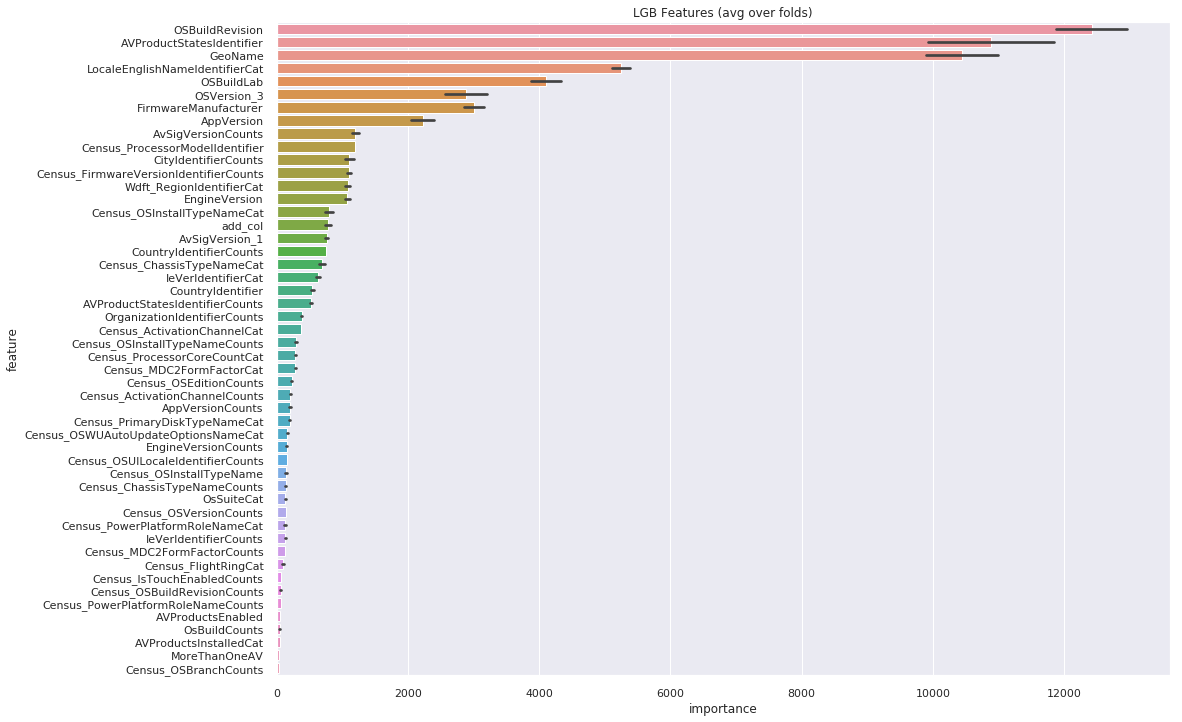

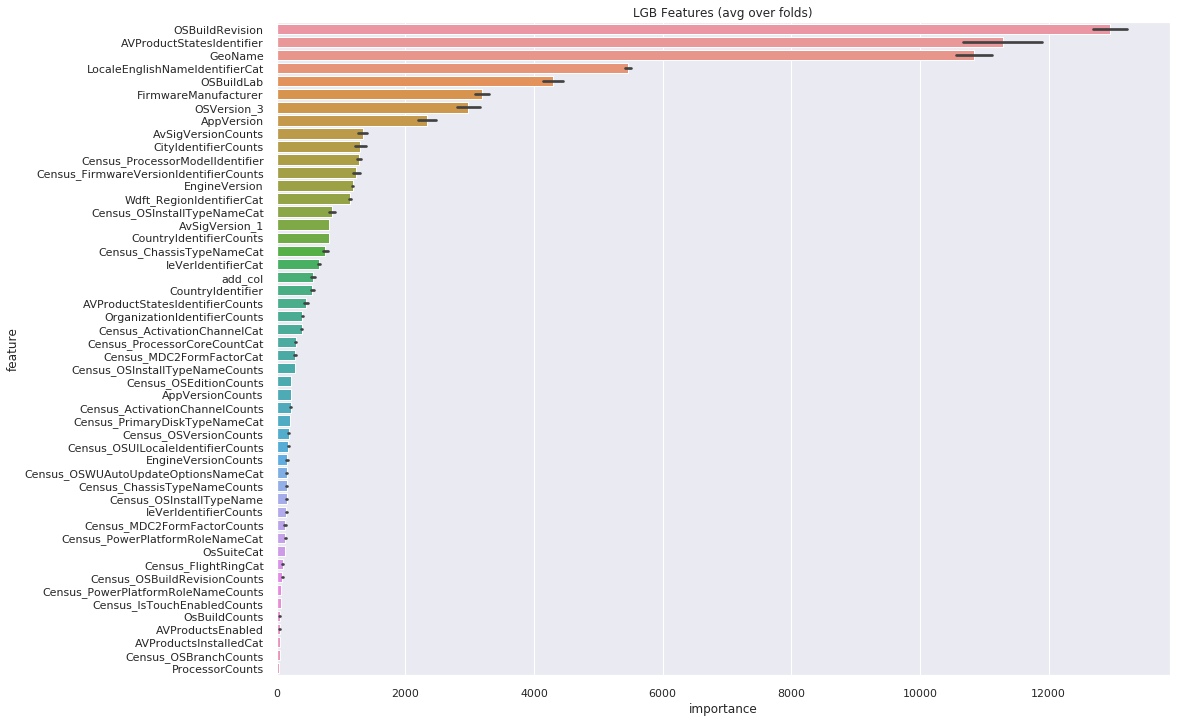

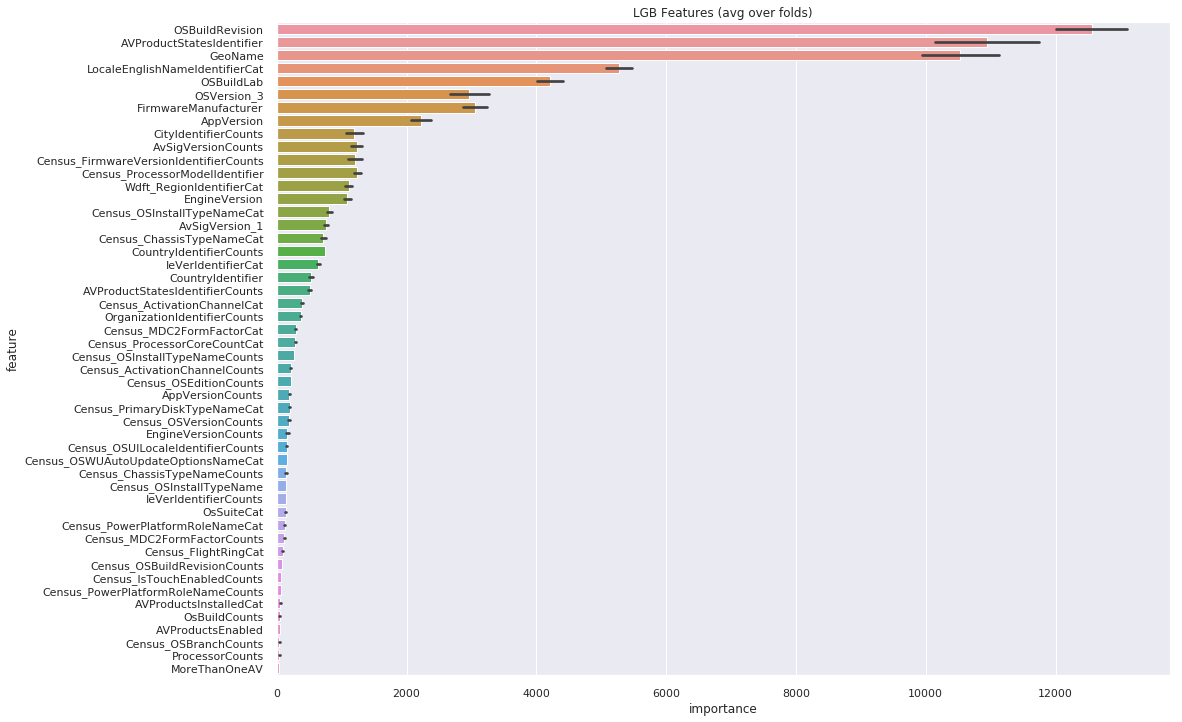

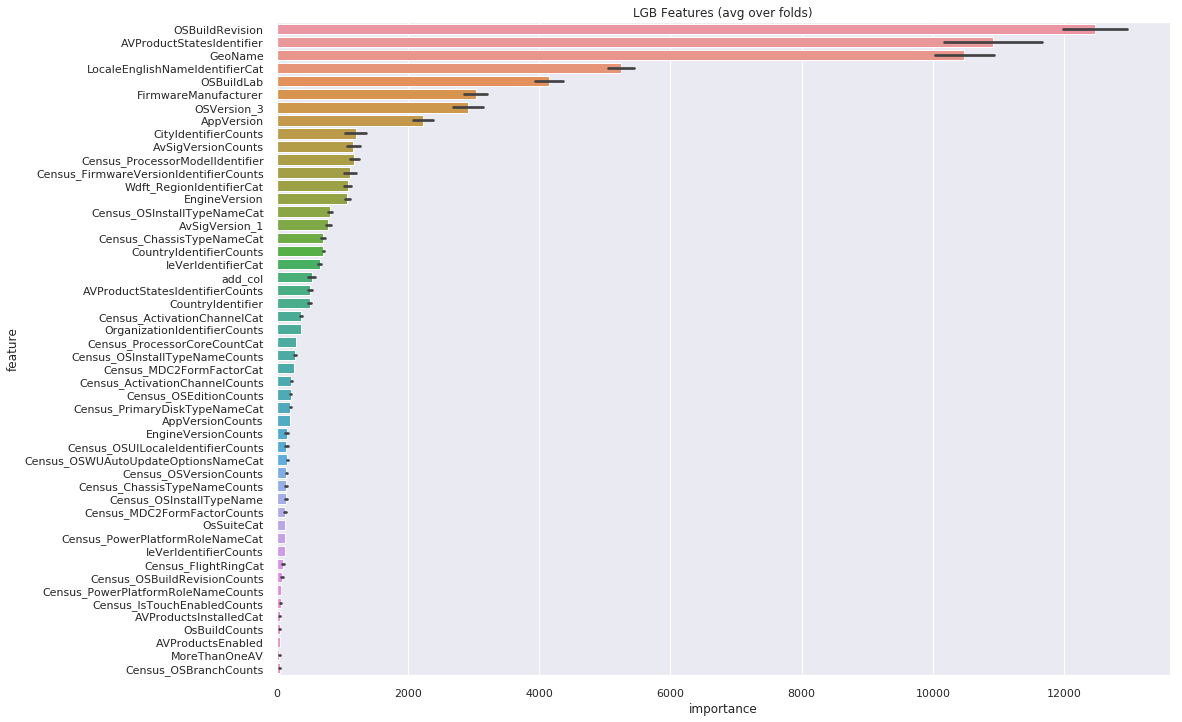

In [57]:
result_dicts = {}
for i in range(len(counts_to_try)):
    for j in range(len(counts_to_try)):
        if i==j:
            continue
        else:
            print('running ' + str(i) + ' ' + str(j))
            train_l1['add_col'] = train_l1[counts_to_try[i]] + train_l1[counts_to_try[j]]
            test_l1['add_col'] = test_l1[counts_to_try[i]] + test_l1[counts_to_try[j]]
            
            result_dicts[str(i) + '_'+ str(j)] = train_model(X=train_l1, X_test=test_l1, y=labels, params=params, model_type='lgb', plot_feature_importance=True, averaging='usual')

In [ ]:
result_dict1 = train_model(X=train_l1, X_test=test_l1, y=labels, params=params, model_type='lgb', plot_feature_importance=True, averaging='usual')

In [48]:
result_dict1['feature_importance'][30:73]

,feature,importance,fold
30,AvSigVersionCounts,524.2,1
31,AVProductStatesIdentifierCounts,478.8,1
32,CountryIdentifierCounts,204.0,1
33,Census_OSVersionCounts,261.6,1
34,CityIdentifierCounts,4204.4,1
35,OrganizationIdentifierCounts,15.2,1
36,ProcessorCounts,0.0,1
37,IeVerIdentifierCounts,13.4,1
38,Census_MDC2FormFactorCounts,5.4,1
39,OsBuildCounts,15.2,1


In [26]:
submission = pd.read_csv('/home/ryan/cs/datasets/microsoft/sample_submission.csv')
submission['HasDetections'] = result_dict1['prediction']
submission.to_csv('v1.csv', index=False)

In [27]:
result_dict1.keys()

dict_keys(['prediction', 'feature_importance'])

In [28]:
test_l1.head()

,MoreThanOneAV,AVProductsEnabled,SkuCondensed,IsProtected,SmartScreen,CountryIdentifier,EngineVersionMapped,EngineVersion_0,EngineVersion_1,EngineVersion_2,EngineVersion_3,AppVersionMapped,AppVersion_0,AppVersion_1,AppVersion_2,AppVersion_3,IeVerIdentifier,ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_InternalPrimaryDiagonalDisplaySizeInInches,BatteryType,BatteryNumberOfCharges,AvSigVersionMapped,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,PlatformCounts,EngineVersionCounts,AppVersionCounts,AvSigVersionCounts,AVProductStatesIdentifierCounts,CountryIdentifierCounts,Census_OSVersionCounts,CityIdentifierCounts,OrganizationIdentifierCounts,ProcessorCounts,IeVerIdentifierCounts,Census_MDC2FormFactorCounts,OsBuildCounts,Census_ChassisTypeNameCounts,Census_PowerPlatformRoleNameCounts,Census_OSBranchCounts,Census_OSBuildNumberCounts,Census_OSBuildRevisionCounts,Census_OSEditionCounts,Census_OSInstallTypeNameCounts,Census_ActivationChannelCounts,Census_FirmwareVersionIdentifierCounts,Census_IsTouchEnabledCounts,Census_OSUILocaleIdentifierCounts,OrganizationIdentifierFreqs,CountryIdentifierFreqs,IeVerIdentifierFreqs,Census_ActivationChannelFreqs,Census_FirmwareManufacturerIdentifierFreqs,Census_OSUILocaleIdentifierFreqs,AVProductsInstalledCat,LocaleEnglishNameIdentifierCat,PlatformCat,ProcessorCat,OsBuildCat,OsSuiteCat,OsPlatformSubReleaseCat,IeVerIdentifierCat,Census_MDC2FormFactorCat,Census_ProcessorCoreCountCat,Census_ProcessorManufacturerIdentifierCat,Census_PrimaryDiskTypeNameCat,Census_ChassisTypeNameCat,Census_PowerPlatformRoleNameCat,Census_OSBranchCat,Census_OSInstallTypeNameCat,Census_OSWUAutoUpdateOptionsNameCat,Census_ActivationChannelCat,Census_FlightRingCat,Wdft_RegionIdentifierCat,Census_PrimaryDiskTotalCapacityGB,Census_SystemVolumeTotalCapacityGB,Census_TotalPhysicalRAMGB,IsProtectedBool,SModeBool,FirewallBool,Census_HasOpticalDiskDriveBool,Census_GenuineStateNameBool,Census_IsSecureBootEnabledBool,Census_IsTouchEnabledBool,Census_IsPenCapableBool,Census_IsAlwaysOnAlwaysConnectedCapableBool,Wdft_IsGamerBool,OSVerOrdinal,GeoName,OSBuildRevision,OSBuildLab,FirmwareManufacturer,AppVersion,AVProductStatesIdentifier,OSVersion_0,OSVersion_1,OSVersion_2,OSVersion_3,EngineVersion,Census_OSInstallTypeName
0,0,1.0,Home,True,False,43.0,NaN,1,1,NaN,NaN,NaN,4,18.0,NaN,NaN,108.0,4.0,3064.0,15.500000,0,8,NaN,1.0,NaN,501.0,0,8618715,NaN,NaN,NaN,5824565.0,397172.0,NaN,6469.0,1764175.0,NaN,474390.0,5723319.0,780270.0,5248812.0,6182908.0,797066.0,797049.0,NaN,3469991.0,649201,3413350,223.0,7801452,408118.0,0.505705,0.512030,0.476410,0.496623,0.475365,0.517929,1.0,42.0,windows10,NaN,15063.0,768.0,rs2,108.0,Notebook,4.0,5.0,SSD,Notebook,Mobile,rs2_release,Reset,AutoInstallAndRebootAtMaintenanceTime,OEM:DM,Retail,7.0,488.0,123.0,8.0,True,NaN,True,False,True,True,False,False,False,False,NaN,53.0,NaN,15063.0.amd64fre.rs2_release.170317-1834,807.0,NaN,53447.0,10,0,15063,NaN,NaN,Reset
1,0,1.0,Home,True,True,68.0,NaN,1,1,NaN,NaN,NaN,4,18.0,NaN,NaN,117.0,4.0,3410.0,15.500000,0,0,NaN,1.0,NaN,NaN,0,8618715,NaN,NaN,NaN,5824565.0,160158.0,216776.0,262.0,NaN,NaN,1767931.0,5723319.0,2503681.0,5248812.0,6182908.0,1199767.0,2443249.0,216776.0,3469991.0,2608037,4727589,89611.0,7801452,513995.0,NaN,0.479183,0.493868,0.491946,0.510175,0.485310,1.0,74.0,windows10,NaN,16299.0,768.0,rs3,117.0,Notebook,4.0,5.0,HDD,Notebook,Mobile,rs3_release_svc_escrow,UUPUpgrade,AutoInstallAndRebootAtMaintenanceTime,Retail,Retail,12.0,1907.0,NaN,8.0,True,NaN,True,False,True,True,False,False,False,True,NaN,276.0,611.0,16299.431.amd64fre.rs3_release_svc_escrow.1805...,554.0,NaN,53447.0,10,0,16299,611,NaN,UUPUpgrade
2,1,1.0,Home,True,True,201.0,66.0,1,1,NaN,NaN,NaN,4,18.0,NaN,NaN,98.0,2.0,2096.0,13.898438,0,0,8463.0,1.0,NaN,230.0,0,8618715,NaN,NaN,NaN,99899.0,220622.0,223775.0,64286.0,NaN,NaN,354411.0,5723319.0,730819.0,5248812.0,6182908.0,785534.0,785450.0,223775.0,1945461.0,840121,3413350,33316.0,7801452,206854.0,NaN,0.510665,0.475919,0.496623,0.50469

In [29]:
train_l1.head()

,MoreThanOneAV,AVProductsEnabled,SkuCondensed,IsProtected,SmartScreen,CountryIdentifier,EngineVersionMapped,EngineVersion_0,EngineVersion_1,EngineVersion_2,EngineVersion_3,AppVersionMapped,AppVersion_0,AppVersion_1,AppVersion_2,AppVersion_3,IeVerIdentifier,ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_InternalPrimaryDiagonalDisplaySizeInInches,BatteryType,BatteryNumberOfCharges,AvSigVersionMapped,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,PlatformCounts,EngineVersionCounts,AppVersionCounts,AvSigVersionCounts,AVProductStatesIdentifierCounts,CountryIdentifierCounts,Census_OSVersionCounts,CityIdentifierCounts,OrganizationIdentifierCounts,ProcessorCounts,IeVerIdentifierCounts,Census_MDC2FormFactorCounts,OsBuildCounts,Census_ChassisTypeNameCounts,Census_PowerPlatformRoleNameCounts,Census_OSBranchCounts,Census_OSBuildNumberCounts,Census_OSBuildRevisionCounts,Census_OSEditionCounts,Census_OSInstallTypeNameCounts,Census_ActivationChannelCounts,Census_FirmwareVersionIdentifierCounts,Census_IsTouchEnabledCounts,Census_OSUILocaleIdentifierCounts,OrganizationIdentifierFreqs,CountryIdentifierFreqs,IeVerIdentifierFreqs,Census_ActivationChannelFreqs,Census_FirmwareManufacturerIdentifierFreqs,Census_OSUILocaleIdentifierFreqs,AVProductsInstalledCat,LocaleEnglishNameIdentifierCat,PlatformCat,ProcessorCat,OsBuildCat,OsSuiteCat,OsPlatformSubReleaseCat,IeVerIdentifierCat,Census_MDC2FormFactorCat,Census_ProcessorCoreCountCat,Census_ProcessorManufacturerIdentifierCat,Census_PrimaryDiskTypeNameCat,Census_ChassisTypeNameCat,Census_PowerPlatformRoleNameCat,Census_OSBranchCat,Census_OSInstallTypeNameCat,Census_OSWUAutoUpdateOptionsNameCat,Census_ActivationChannelCat,Census_FlightRingCat,Wdft_RegionIdentifierCat,Census_PrimaryDiskTotalCapacityGB,Census_SystemVolumeTotalCapacityGB,Census_TotalPhysicalRAMGB,IsProtectedBool,SModeBool,FirewallBool,Census_HasOpticalDiskDriveBool,Census_GenuineStateNameBool,Census_IsSecureBootEnabledBool,Census_IsTouchEnabledBool,Census_IsPenCapableBool,Census_IsAlwaysOnAlwaysConnectedCapableBool,Wdft_IsGamerBool,OSVerOrdinal,GeoName,OSBuildRevision,OSBuildLab,FirmwareManufacturer,AppVersion,AVProductStatesIdentifier,OSVersion_0,OSVersion_1,OSVersion_2,OSVersion_3,EngineVersion,Census_OSInstallTypeName
0,0,1.0,Pro,True,False,29.0,66.0,1,1,NaN,NaN,NaN,4,18.0,NaN,NaN,137.0,4.0,2340.0,18.906250,0,0,NaN,1.0,NaN,NaN,0,8618715,NaN,NaN,NaN,5824565.0,347991.0,NaN,6261.0,1764175.0,NaN,3885842.0,1951086.0,3915521.0,1872125.0,2066620.0,4009158.0,4008881.0,NaN,3130566.0,2608037,4727589,455.0,7801452,337988.0,0.505705,0.505318,0.52082,0.491946,0.501592,0.508882,1.0,-85.0,windows10,NaN,17134.0,256.0,rs4,137.0,Desktop,4.0,5.0,HDD,Desktop,Desktop,rs4_release,UUPUpgrade,UNKNOWN,Retail,Retail,10.0,476.0,299.0,4.0,True,NaN,True,False,True,False,False,False,False,False,NaN,35.0,NaN,17134.1.amd64fre.rs4_release.180410-1804,628.0,NaN,53447.0,10,0,17134,NaN,NaN,UUPUpgrade
1,0,1.0,Pro,True,False,93.0,NaN,1,1,14600.0,NaN,NaN,4,13.0,17134.0,1.0,137.0,4.0,2404.0,13.898438,0,1,NaN,1.0,263,48.0,0,8618715,160585.0,257270.0,98024.0,5824565.0,283625.0,100759.0,7913.0,1764175.0,NaN,3885842.0,5723319.0,3915521.0,5248812.0,6182908.0,4009158.0,4008881.0,106583.0,3130566.0,1650733,4727589,693.0,7801452,3170824.0,0.505705,0.492203,0.52082,0.491946,0.501592,0.506770,1.0,64.0,windows10,NaN,17134.0,256.0,rs4,137.0,Notebook,4.0,5.0,HDD,Notebook,Mobile,rs4_release,IBSClean,UNKNOWN,Retail,NOT_SET,8.0,476.0,102.0,4.0,True,NaN,True,False,True,False,False,False,False,False,375.0,119.0,1.0,17134.1.amd64fre.rs4_release.180410-1804,628.0,4.13.17134.1,53447.0,10,0,17134,1,1.1.14600.4,IBSClean
2,0,1.0,Home,True,True,86.0,66.0,1,1,NaN,NaN,NaN,4,18.0,NaN,NaN,137.0,4.0,1972.0,21.500000,0,0,NaN,1.0,NaN,NaN,0,8618715,NaN,NaN,NaN,5824565.0,41214.0,NaN,1820.0,1764175.0,NaN,3885842.0,1951086.0,3915521.0,1872125.0,2066620.0,4009158.0,4008881.0,NaN,3469991.0,2608037,317980,6704.0,7801452,513995.0,0.505705,0.499127,0.52082,0.519655,0.518790,0.485310,1.0,49.0,w

In [30]:
submission.head()

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.585737
1,00000176ac758d54827acd545b6315a5,0.621867
2,0000019dcefc128c2d4387c1273dae1d,0.558351
3,0000055553dc51b1295785415f1a224d,0.402051
4,00000574cefffeca83ec8adf9285b2bf,0.522317
